In [1]:
import numpy as np
import cytnx
import matplotlib.pyplot as plt
import cProfile
from scipy.optimize import curve_fit

In [2]:
def ut_print(ut,print_numpy = True):
    ut.print_diagram()
    if print_numpy:
        print(ut.get_block().numpy())

def get_M(T):
    W = np.array([[np.exp(1/T),np.exp(-1/T)],
                  [np.exp(-1/T),np.exp(1/T)]])
    W = cytnx.from_numpy(W)
    S,U,Vd = cytnx.linalg.Svd(W)
    M = U @ cytnx.linalg.Diag(S.Pow(0.5))
    M = cytnx.UniTensor(M, rowrank = 1)
    M.set_name('M')
    Md = cytnx.linalg.Diag(S.Pow(0.5)) @ Vd
    Md = cytnx.UniTensor(Md, rowrank = 1)
    Md.set_name('Md')
    return M,Md

def get_delta(h):
    delta = cytnx.zeros([2,2,2,2])
    delta[0,0,0,0] = 1
    delta[1,1,1,1] = 1
    delta = cytnx.UniTensor(delta, rowrank = 2)
    delta.set_name('delta')
    return delta

def get_T_baret(T,h=0):
    ut_M, ut_Md = get_M(T)
    ut_delta = get_delta(h)
    Ising_net = cytnx.Network('./Networks/Ising_square.net')
    Ising_net.PutUniTensors(['delta', 'M0.d', 'M1.d', 'M2', 'M3'],
                            [ut_delta, ut_Md, ut_Md, ut_M, ut_M])
    T_bare = Ising_net.Launch(optimal=True)
    T_bare.set_name('T_bare')
    return T_bare

def merge_y(Tup,Tdn, combine = False, trace = False):
    if trace:
        TupTdn_net = cytnx.Network('./Networks/merge_y_trace.net')
    else:
        TupTdn_net = cytnx.Network('./Networks/merge_y.net')
    TupTdn_net.PutUniTensors(['Tup', 'Tdn'],
                             [Tup, Tdn])
    TupTdn = TupTdn_net.Launch(optimal=True)
    if combine:
        TupTdn.combineBonds([1,2])
        TupTdn.combineBonds([3,4])
    return TupTdn

def merge_y_truncate(Tup, Tdn, dcut):
    if ((Tup.shape()[1]*Tdn.shape()[1]) < dcut):
        return merge_y(Tup, Tdn,True)
    TupTdn_pure_net = cytnx.Network('./Networks/merge_y_pure.net')
    TupTdn_pure_net.PutUniTensors(['Tup', 'Tdn','Tupd','Tdnd'],
                                  [Tup, Tdn,Tup,Tdn])
    TupTdn_pure = TupTdn_pure_net.Launch(optimal=True)
    _,U,__ = cytnx.linalg.Svd_truncate(TupTdn_pure,dcut)
    TupTdn_net = cytnx.Network('./Networks/merge_y_truncate.net')
    TupTdn_net.PutUniTensors(['Tup', 'Tdn','UL','UR'],
                             [Tup, Tdn,U,U])
    TupTdn = TupTdn_net.Launch(optimal=True)
    return TupTdn

def merge_x(TL,TR, combine = False, trace = False):
    if trace:
        n = TL.shape()[0]
        I = np.eye(n)
        I = cytnx.from_numpy(I)
        I = cytnx.UniTensor(I, rowrank = 1)
        TLTR_net = cytnx.Network('./Networks/merge_x_trace.net')
        TLTR_net.PutUniTensors(['TL', 'TR', 'IL', 'IR'],
                               [TL, TR, I, I])
        TLTR = TLTR_net.Launch(optimal=True)
    else:
        TLTR_net = cytnx.Network('./Networks/merge_x.net')
        TLTR_net.PutUniTensors(['TL', 'TR'],
                               [TL, TR])
        TLTR = TLTR_net.Launch(optimal=True)
    if combine and not trace:
        TLTR.combineBonds([0,1])
        TLTR.combineBonds([4,5])
    return TLTR

def merge_x_truncate(TL, TR, dcut):
    if ((TL.shape()[0]*TR.shape()[0]) < dcut):
        return merge_x(TL, TR,True)
    TLTR_pure_net = cytnx.Network('./Networks/merge_x_pure.net')
    TLTR_pure_net.PutUniTensors(['TL', 'TR','TLd','TRd'],
                                [TL, TR,TL,TR])
    TLTR_pure = TLTR_pure_net.Launch(optimal=True)
    try:
        _,U,__ = cytnx.linalg.Svd_truncate(TLTR_pure,dcut)
    except:
        TLTR_pure.print_diagram()
        _,U,__ = cytnx.linalg.Svd(TLTR_pure,dcut)
    TLTR_net = cytnx.Network('./Networks/merge_x_truncate.net')
    TLTR_net.PutUniTensors(['TL', 'TR','Uup','Udn'],
                           [TL, TR, U, U])
    TLTR = TLTR_net.Launch(optimal=True)
    return TLTR

def trace(T):
    n = T.shape()[0]
    I = np.eye(n)
    I = cytnx.from_numpy(I)
    I = cytnx.UniTensor(I, rowrank = 1)
    trace_net = cytnx.Network('./Networks/trace.net')
    trace_net.PutUniTensors(['T', 'I'],
                             [T, I])
    return trace_net.Launch(optimal=True)

# test truncate

In [3]:
MaxL = 10
Temp = np.linspace(2.26,2.38,200)
W = np.ones((MaxL+1,len(Temp),2))
Tc = 2/np.log(1+np.sqrt(2))

In [4]:
T_bare = get_T_baret(Temp[0])
TL = T_bare
TLx = merge_x_truncate(TL,TL,4)
TL = merge_y_truncate(TLx,TLx,4)
TLx = merge_x_truncate(TL,TL,16)
TL = merge_y_truncate(TLx,TLx,16)
TL.print_diagram()
TL_Trace = trace(TL)
TL_Trace.print_diagram()

-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 16       16 |____ 3  
           |             |     
     1 ____| 16       16 |____ 5  
           \             /     
            -------------      
-----------------------
tensor Name : 
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 16       16 |____ 1  
           \             /     
            -------------      


In [5]:
T_bare = get_T_baret(Temp[0])
TL = T_bare
TLx = merge_x_truncate(TL,TL,4)
TL = merge_y_truncate(TLx,TLx,4)
TLx = merge_x_truncate(TL,TL,16)
TL = merge_y_truncate(TLx,TLx,16)
TL.print_diagram()
TL_Trace_truncate = trace(TL)
TL_Trace_truncate.print_diagram()

-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 16       16 |____ 3  
           |             |     
     1 ____| 16       16 |____ 5  
           \             /     
            -------------      
-----------------------
tensor Name : 
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 16       16 |____ 1  
           \             /     
            -------------      


In [6]:
w,_ = cytnx.linalg.Eigh(TL_Trace.get_block())
w_truncate,_ = cytnx.linalg.Eigh(TL_Trace_truncate.get_block())
print(w.numpy())
print(w_truncate.numpy())
print("Same:",np.allclose(w_truncate.numpy(),w.numpy()))

[1.79910548e-02 3.98728434e-02 7.13437397e+00 7.96018287e+00
 7.96018287e+00 4.73509160e+01 2.66574529e+02 2.66574529e+02
 2.66574529e+02 2.66574529e+02 1.50075195e+03 8.92717927e+03
 8.92717927e+03 9.96050665e+03 1.78221508e+06 3.94985065e+06]
[1.79910548e-02 3.98728434e-02 7.13437397e+00 7.96018287e+00
 7.96018287e+00 4.73509160e+01 2.66574529e+02 2.66574529e+02
 2.66574529e+02 2.66574529e+02 1.50075195e+03 8.92717927e+03
 8.92717927e+03 9.96050665e+03 1.78221508e+06 3.94985065e+06]
Same: True


# N*N truncate test

In [7]:
MaxL = 4
Temp1 = np.linspace(2.26,4,100)
W1 = np.ones((MaxL+1,len(Temp1),2))
E1 = np.ones((MaxL+1,len(Temp1),2))
Tc = 2/np.log(1+np.sqrt(2))

In [8]:
%%time
for i,temp in enumerate(Temp1):
    #print(temp)
    T_bare = get_T_baret(temp)
    TL = T_bare
    for j in range(2,MaxL+1):
        TL_Trace = merge_y(TL,TL,True,True)
        w,v = cytnx.linalg.Eigh(TL_Trace.get_block())
        W1[j,i,:] = w[-2:].numpy()
        TL = merge_y(TL,TL,True)
E1 = -np.log(W1)
Corr_len1 = 1/(E1[:,:,-2]-E1[:,:,-1])

CPU times: user 3min 28s, sys: 13.4 s, total: 3min 41s
Wall time: 5.84 s


/home/TCC0731/anaconda3/envs/cytnx/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


## dcut  = 2

In [9]:
MaxL = 4
dcut = 2
Temp = np.linspace(2.26,4,100)
W = np.ones((MaxL+1,len(Temp),2))
E = np.ones((MaxL+1,len(Temp),2))
Tc = 2/np.log(1+np.sqrt(2))

In [10]:
%%time
for i,temp in enumerate(Temp):
    T_bare = get_T_baret(temp) 
    TL = T_bare
    for j in range(2,MaxL+1):
        #print(j)
        TLx = merge_x_truncate(TL,TL,dcut)
        TL_Trace = merge_y(TLx,TLx,True,True)
        w,v = cytnx.linalg.Eigh(TL_Trace.get_block())
        W[j,i,:] = w[-2:].numpy()
        TL = merge_y_truncate(TLx,TLx,dcut)
        TL = TL/np.mean(np.abs(TL.get_block().numpy()))
E = -np.log(W)
Corr_len = 1/(E[:,:,-2]-E[:,:,-1])

CPU times: user 2min 28s, sys: 6.64 s, total: 2min 34s
Wall time: 4.06 s


/home/TCC0731/anaconda3/envs/cytnx/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


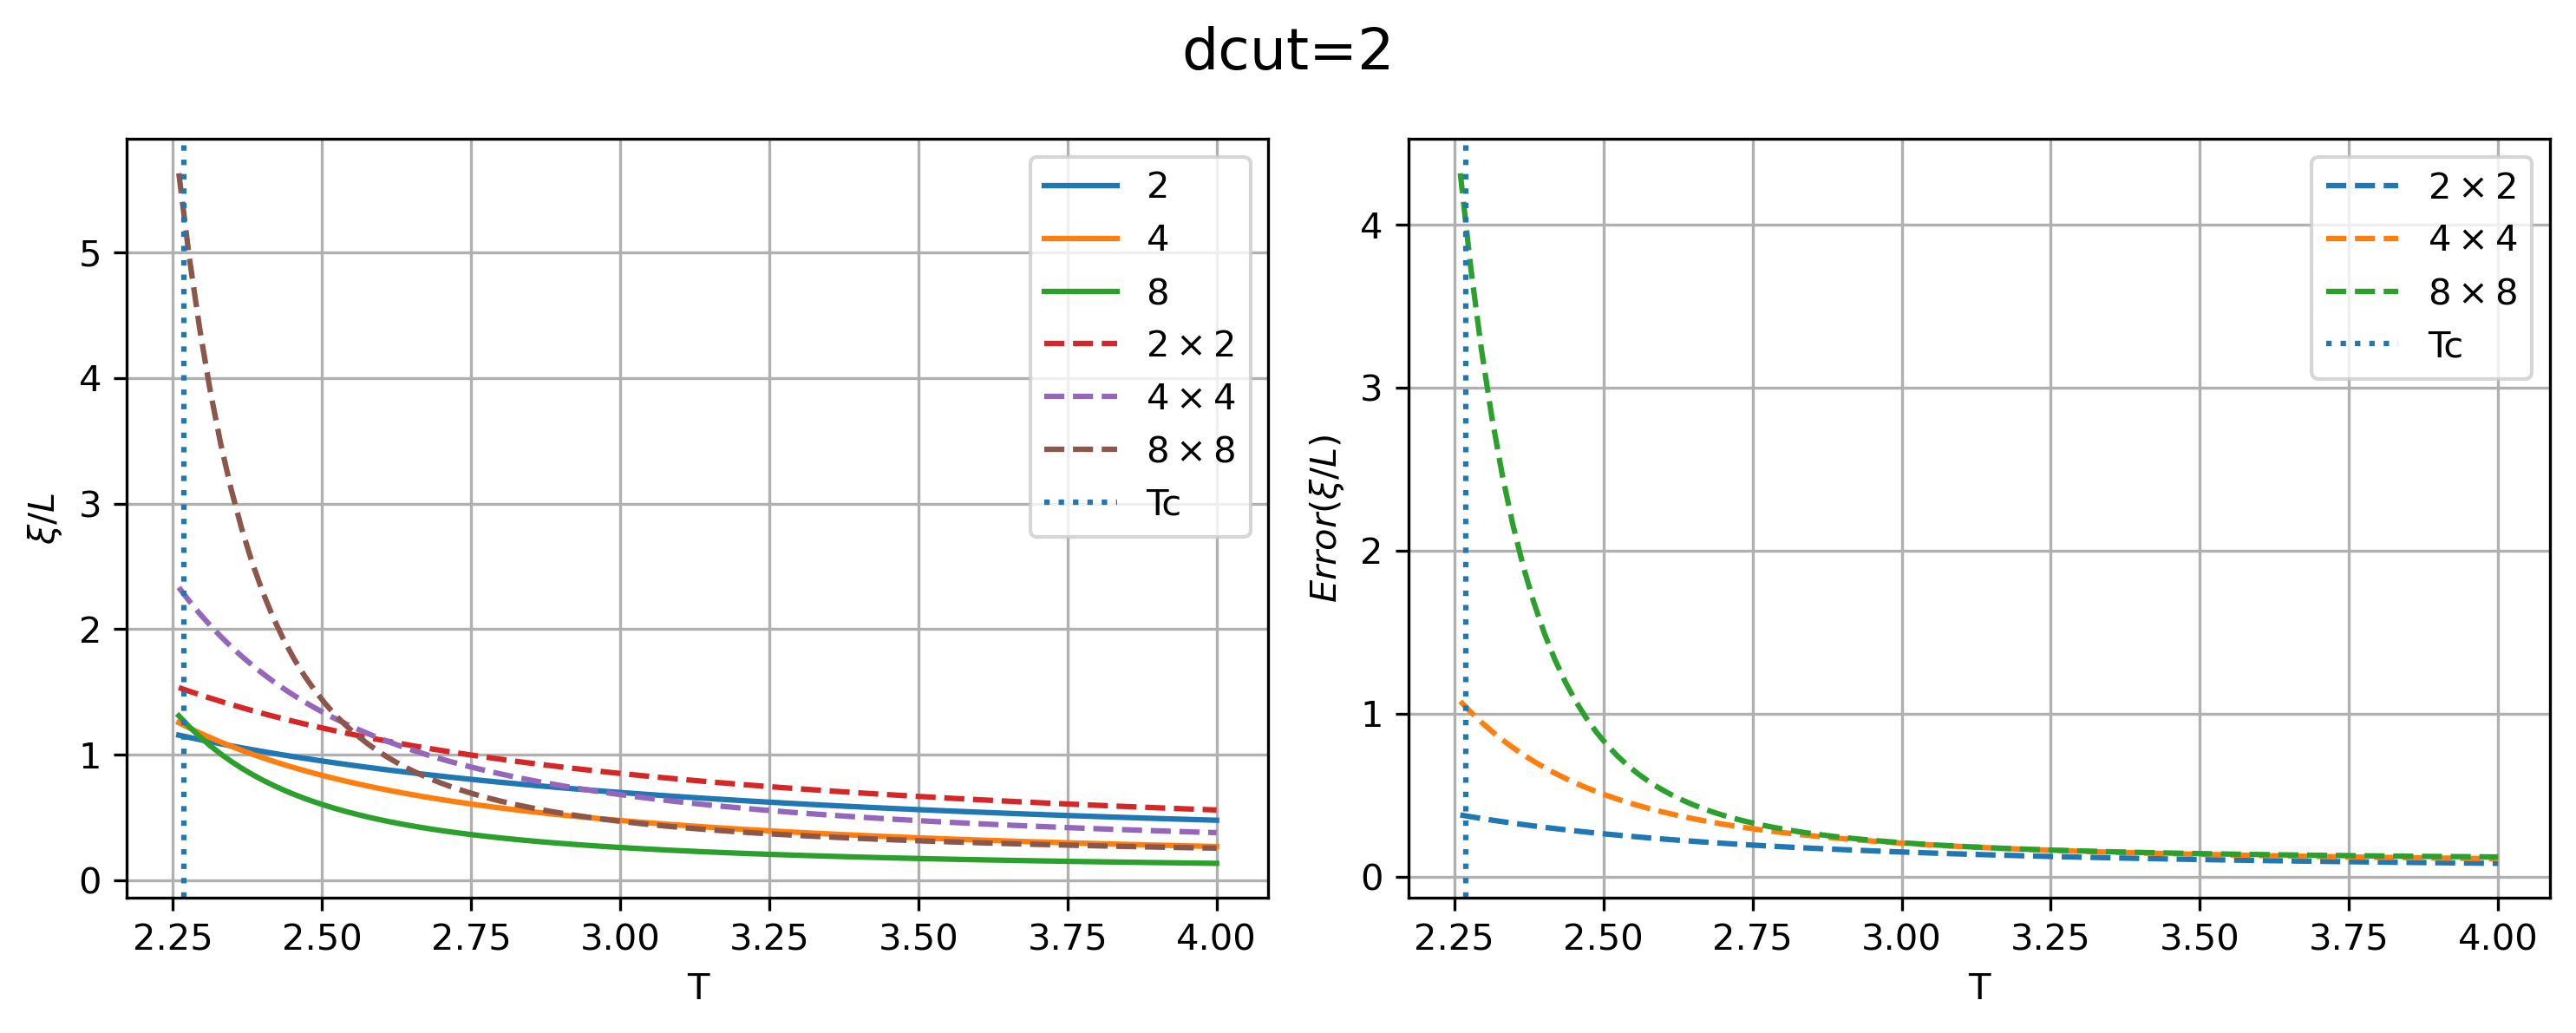

In [11]:
plt.figure(figsize = (10,4),dpi = 300)
plt.suptitle(f'dcut={dcut}',fontsize = 16)
plt.subplot(1,2,1)
for i in range(2,MaxL+1):
    plt.plot(Temp1,Corr_len1[i]/2**(i-1),'-',label = f'${2**(i-1)}$')
for i in range(2,MaxL+1):
    plt.plot(Temp,Corr_len[i],'--',label = f'${2**(i-1)}\\times{2**(i-1)}$')
plt.axvline(x=Tc,ls=':',label = 'Tc')
plt.xlabel('T')
plt.ylabel(r'$\xi/L$')
plt.grid()
plt.legend()
plt.subplot(1,2,2)
for i in range(2,MaxL+1):
    plt.plot(Temp,Corr_len[i] - (Corr_len1[i]/2**(i-1)),'--',label = f'${2**(i-1)}\\times{2**(i-1)}$')
plt.axvline(x=Tc,ls=':',label = 'Tc')
plt.xlabel('T')
plt.ylabel(r'$Error(\xi/L)$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## dcut  = 4

In [12]:
MaxL = 4
dcut = 4
Temp = np.linspace(2.26,4,100)
W = np.ones((MaxL+1,len(Temp),2))
E = np.ones((MaxL+1,len(Temp),2))
Tc = 2/np.log(1+np.sqrt(2))

In [13]:
%%time
for i,temp in enumerate(Temp):
    T_bare = get_T_baret(temp) 
    TL = T_bare
    for j in range(2,MaxL+1):
        #print(j)
        TLx = merge_x_truncate(TL,TL,dcut)
        TL_Trace = merge_y(TLx,TLx,True,True)
        w,v = cytnx.linalg.Eigh(TL_Trace.get_block())
        W[j,i,:] = w[-2:].numpy()
        TL = merge_y_truncate(TLx,TLx,dcut)
        TL = TL/np.mean(np.abs(TL.get_block().numpy()))
E = -np.log(W)
Corr_len = 1/(E[:,:,-2]-E[:,:,-1])

CPU times: user 4min 34s, sys: 14.1 s, total: 4min 48s
Wall time: 7.75 s


/home/TCC0731/anaconda3/envs/cytnx/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


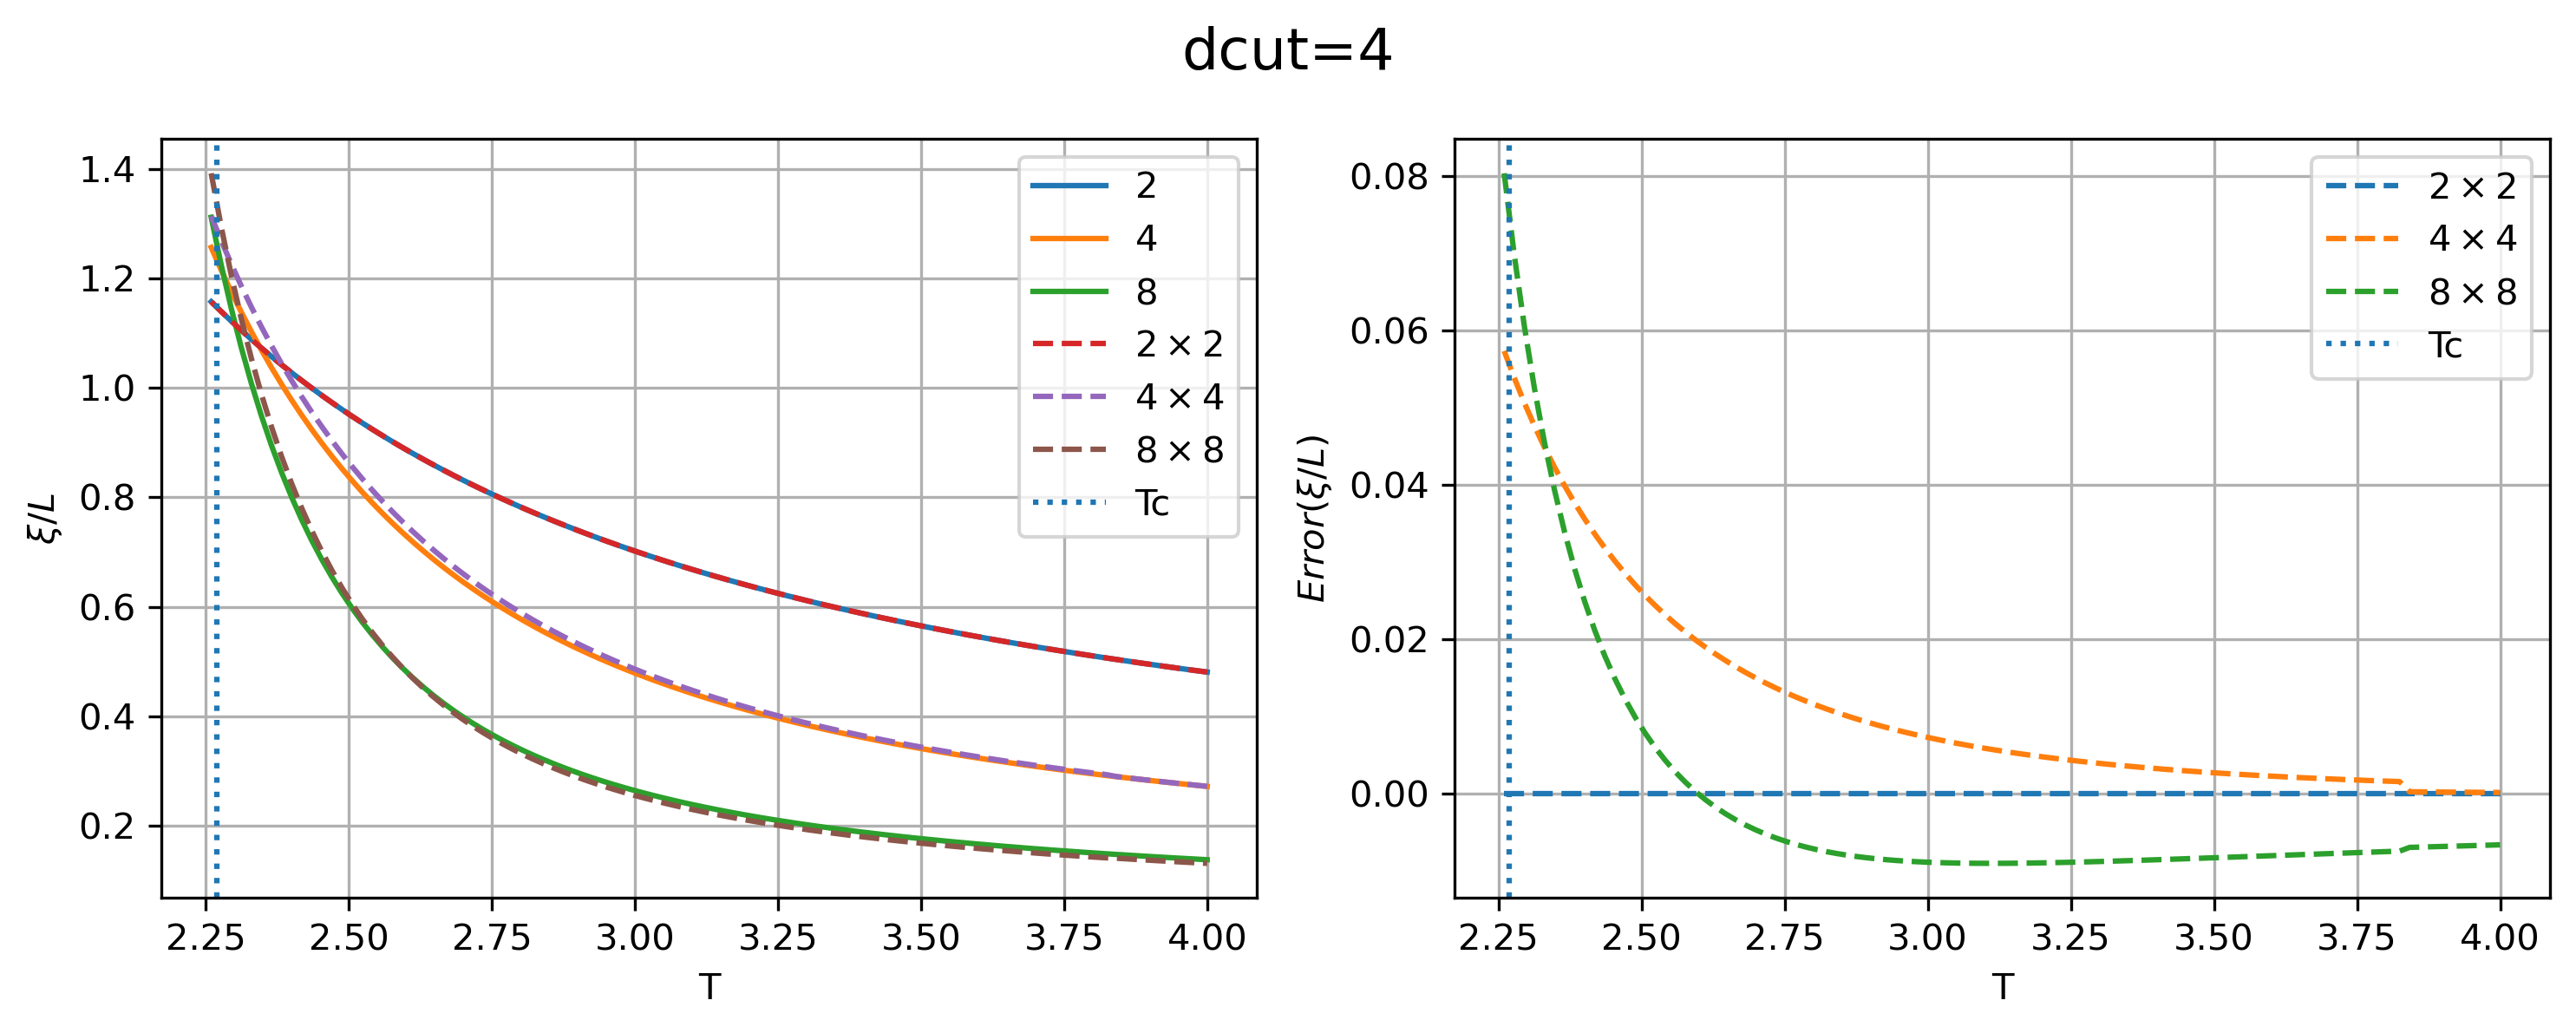

In [14]:
plt.figure(figsize = (10,4),dpi = 300)
plt.suptitle(f'dcut={dcut}',fontsize = 16)
plt.subplot(1,2,1)
for i in range(2,MaxL+1):
    plt.plot(Temp1,Corr_len1[i]/2**(i-1),'-',label = f'${2**(i-1)}$')
for i in range(2,MaxL+1):
    plt.plot(Temp,Corr_len[i],'--',label = f'${2**(i-1)}\\times{2**(i-1)}$')
plt.axvline(x=Tc,ls=':',label = 'Tc')
plt.xlabel('T')
plt.ylabel(r'$\xi/L$')
plt.grid()
plt.legend()
plt.subplot(1,2,2)
for i in range(2,MaxL+1):
    plt.plot(Temp,Corr_len[i] - (Corr_len1[i]/2**(i-1)),'--',label = f'${2**(i-1)}\\times{2**(i-1)}$')
plt.axvline(x=Tc,ls=':',label = 'Tc')
plt.xlabel('T')
plt.ylabel(r'$Error(\xi/L)$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## dcut  = 10

In [15]:
MaxL = 4
dcut = 10
Temp = np.linspace(2.26,4,100)
W = np.ones((MaxL+1,len(Temp),2))
E = np.ones((MaxL+1,len(Temp),2))
Tc = 2/np.log(1+np.sqrt(2))

In [16]:
%%time
for i,temp in enumerate(Temp):
    T_bare = get_T_baret(temp) 
    TL = T_bare
    for j in range(2,MaxL+1):
        #print(j)
        TLx = merge_x_truncate(TL,TL,dcut)
        TL_Trace = merge_y(TLx,TLx,True,True)
        w,v = cytnx.linalg.Eigh(TL_Trace.get_block())
        W[j,i,:] = w[-2:].numpy()
        TL = merge_y_truncate(TLx,TLx,dcut)
        TL = TL/np.mean(np.abs(TL.get_block().numpy()))
E = -np.log(W)
Corr_len = 1/(E[:,:,-2]-E[:,:,-1])

CPU times: user 2min 17s, sys: 5.43 s, total: 2min 23s
Wall time: 3.64 s


/home/TCC0731/anaconda3/envs/cytnx/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


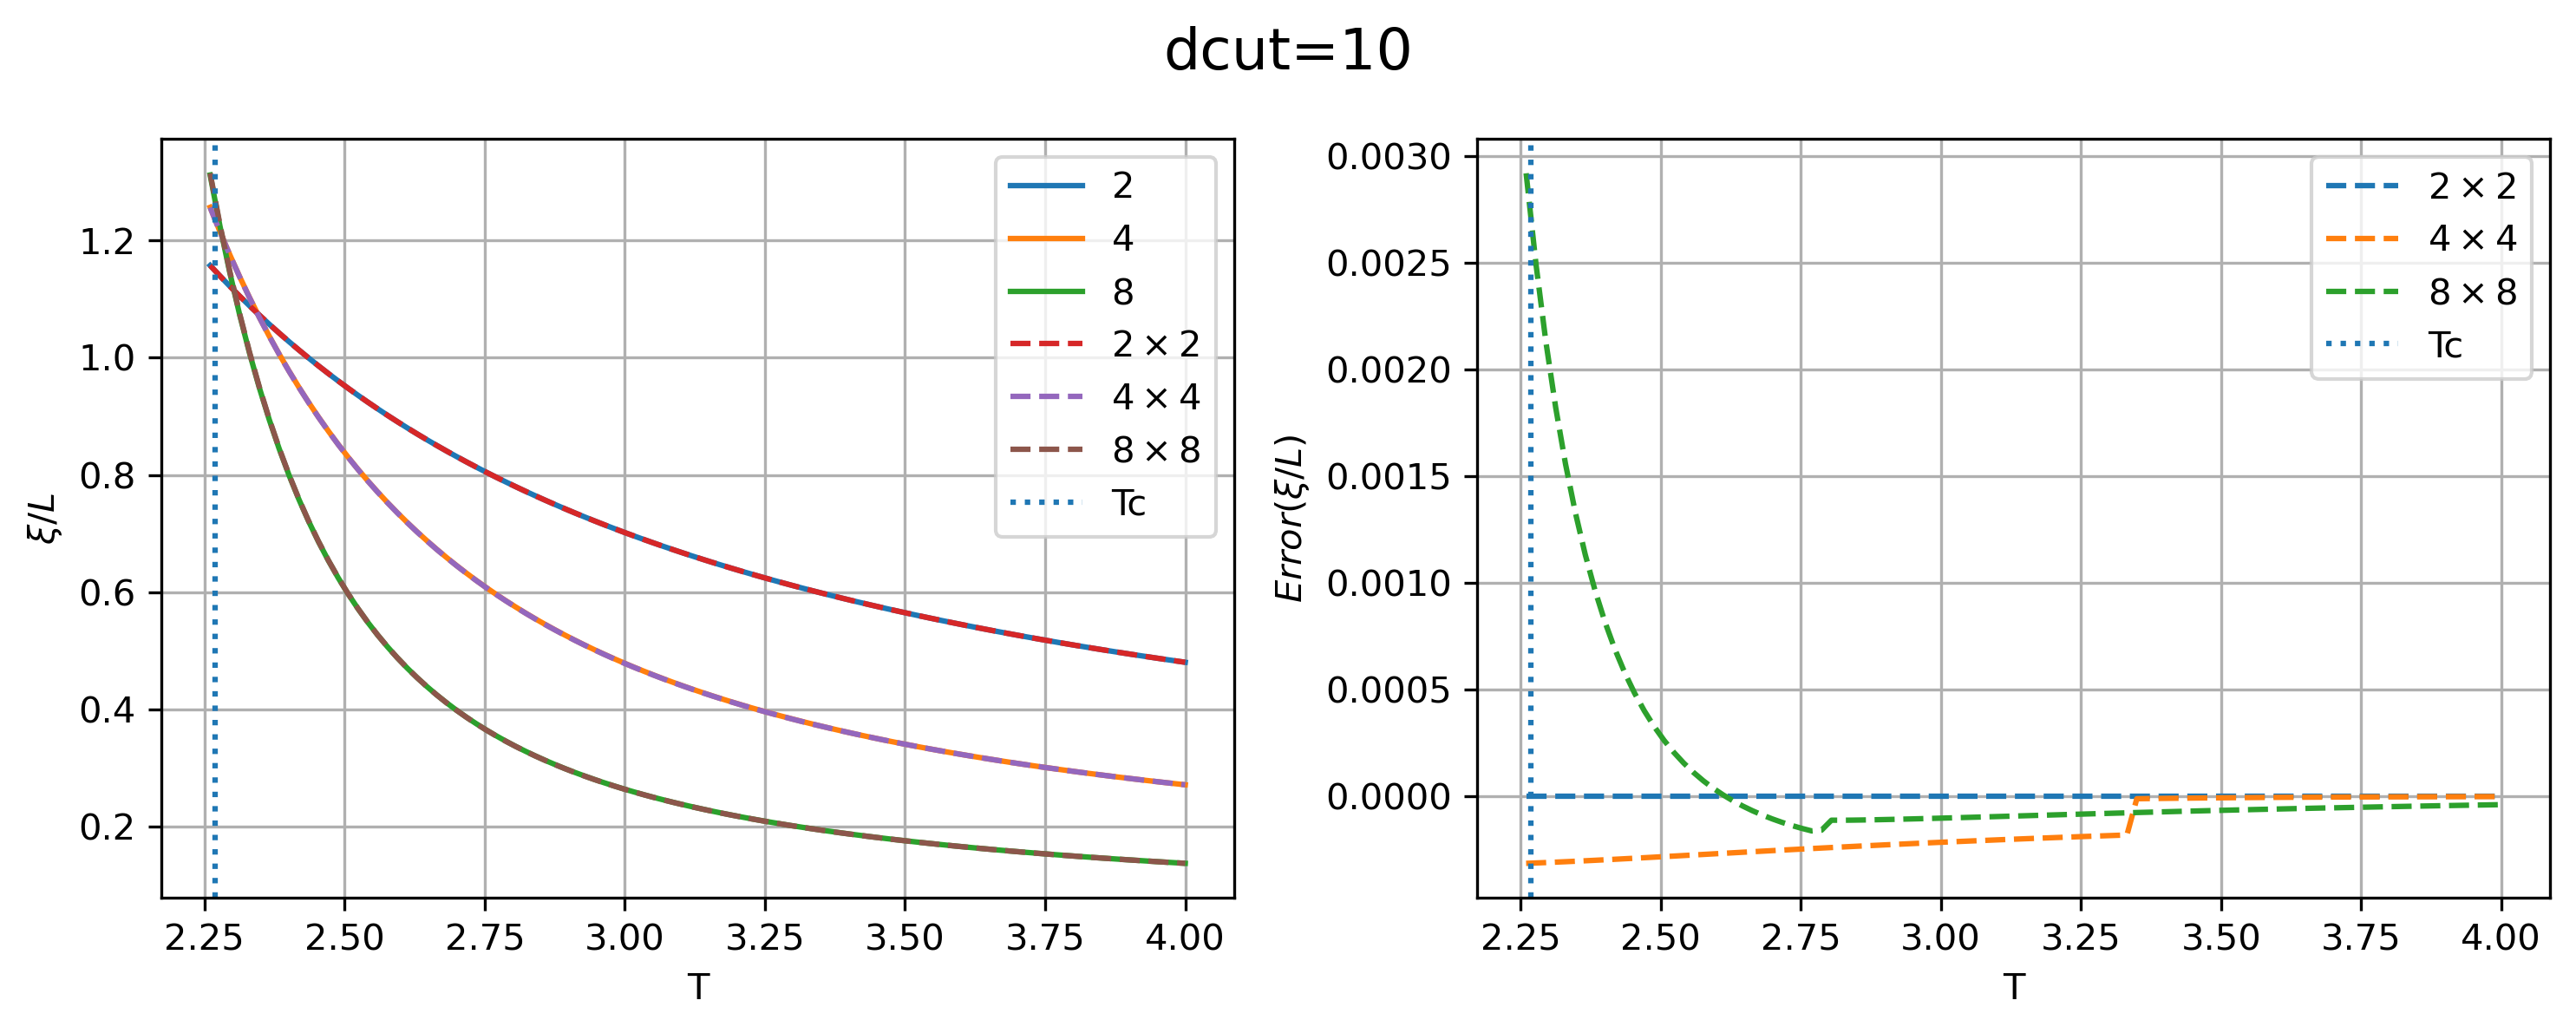

In [17]:
plt.figure(figsize = (10,4),dpi = 300)
plt.suptitle(f'dcut={dcut}',fontsize = 16)
plt.subplot(1,2,1)
for i in range(2,MaxL+1):
    plt.plot(Temp1,Corr_len1[i]/2**(i-1),'-',label = f'${2**(i-1)}$')
for i in range(2,MaxL+1):
    plt.plot(Temp,Corr_len[i],'--',label = f'${2**(i-1)}\\times{2**(i-1)}$')
plt.axvline(x=Tc,ls=':',label = 'Tc')
plt.xlabel('T')
plt.ylabel(r'$\xi/L$')
plt.grid()
plt.legend()
plt.subplot(1,2,2)
for i in range(2,MaxL+1):
    plt.plot(Temp,Corr_len[i] - (Corr_len1[i]/2**(i-1)),'--',label = f'${2**(i-1)}\\times{2**(i-1)}$')
plt.axvline(x=Tc,ls=':',label = 'Tc')
plt.xlabel('T')
plt.ylabel(r'$Error(\xi/L)$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## dcut  = 20

In [18]:
MaxL = 4
dcut = 20
Temp = np.linspace(2.26,4,100)
W = np.ones((MaxL+1,len(Temp),2))
E = np.ones((MaxL+1,len(Temp),2))
Tc = 2/np.log(1+np.sqrt(2))

In [19]:
%%time
for i,temp in enumerate(Temp):
    T_bare = get_T_baret(temp) 
    TL = T_bare
    for j in range(2,MaxL+1):
        #print(j)
        TLx = merge_x_truncate(TL,TL,dcut)
        TL_Trace = merge_y(TLx,TLx,True,True)
        w,v = cytnx.linalg.Eigh(TL_Trace.get_block())
        W[j,i,:] = w[-2:].numpy()
        TL = merge_y_truncate(TLx,TLx,dcut)
        TL = TL/np.mean(np.abs(TL.get_block().numpy()))
E = -np.log(W)
Corr_len = 1/(E[:,:,-2]-E[:,:,-1])

CPU times: user 10min 53s, sys: 35.4 s, total: 11min 28s
Wall time: 17.8 s


/home/TCC0731/anaconda3/envs/cytnx/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


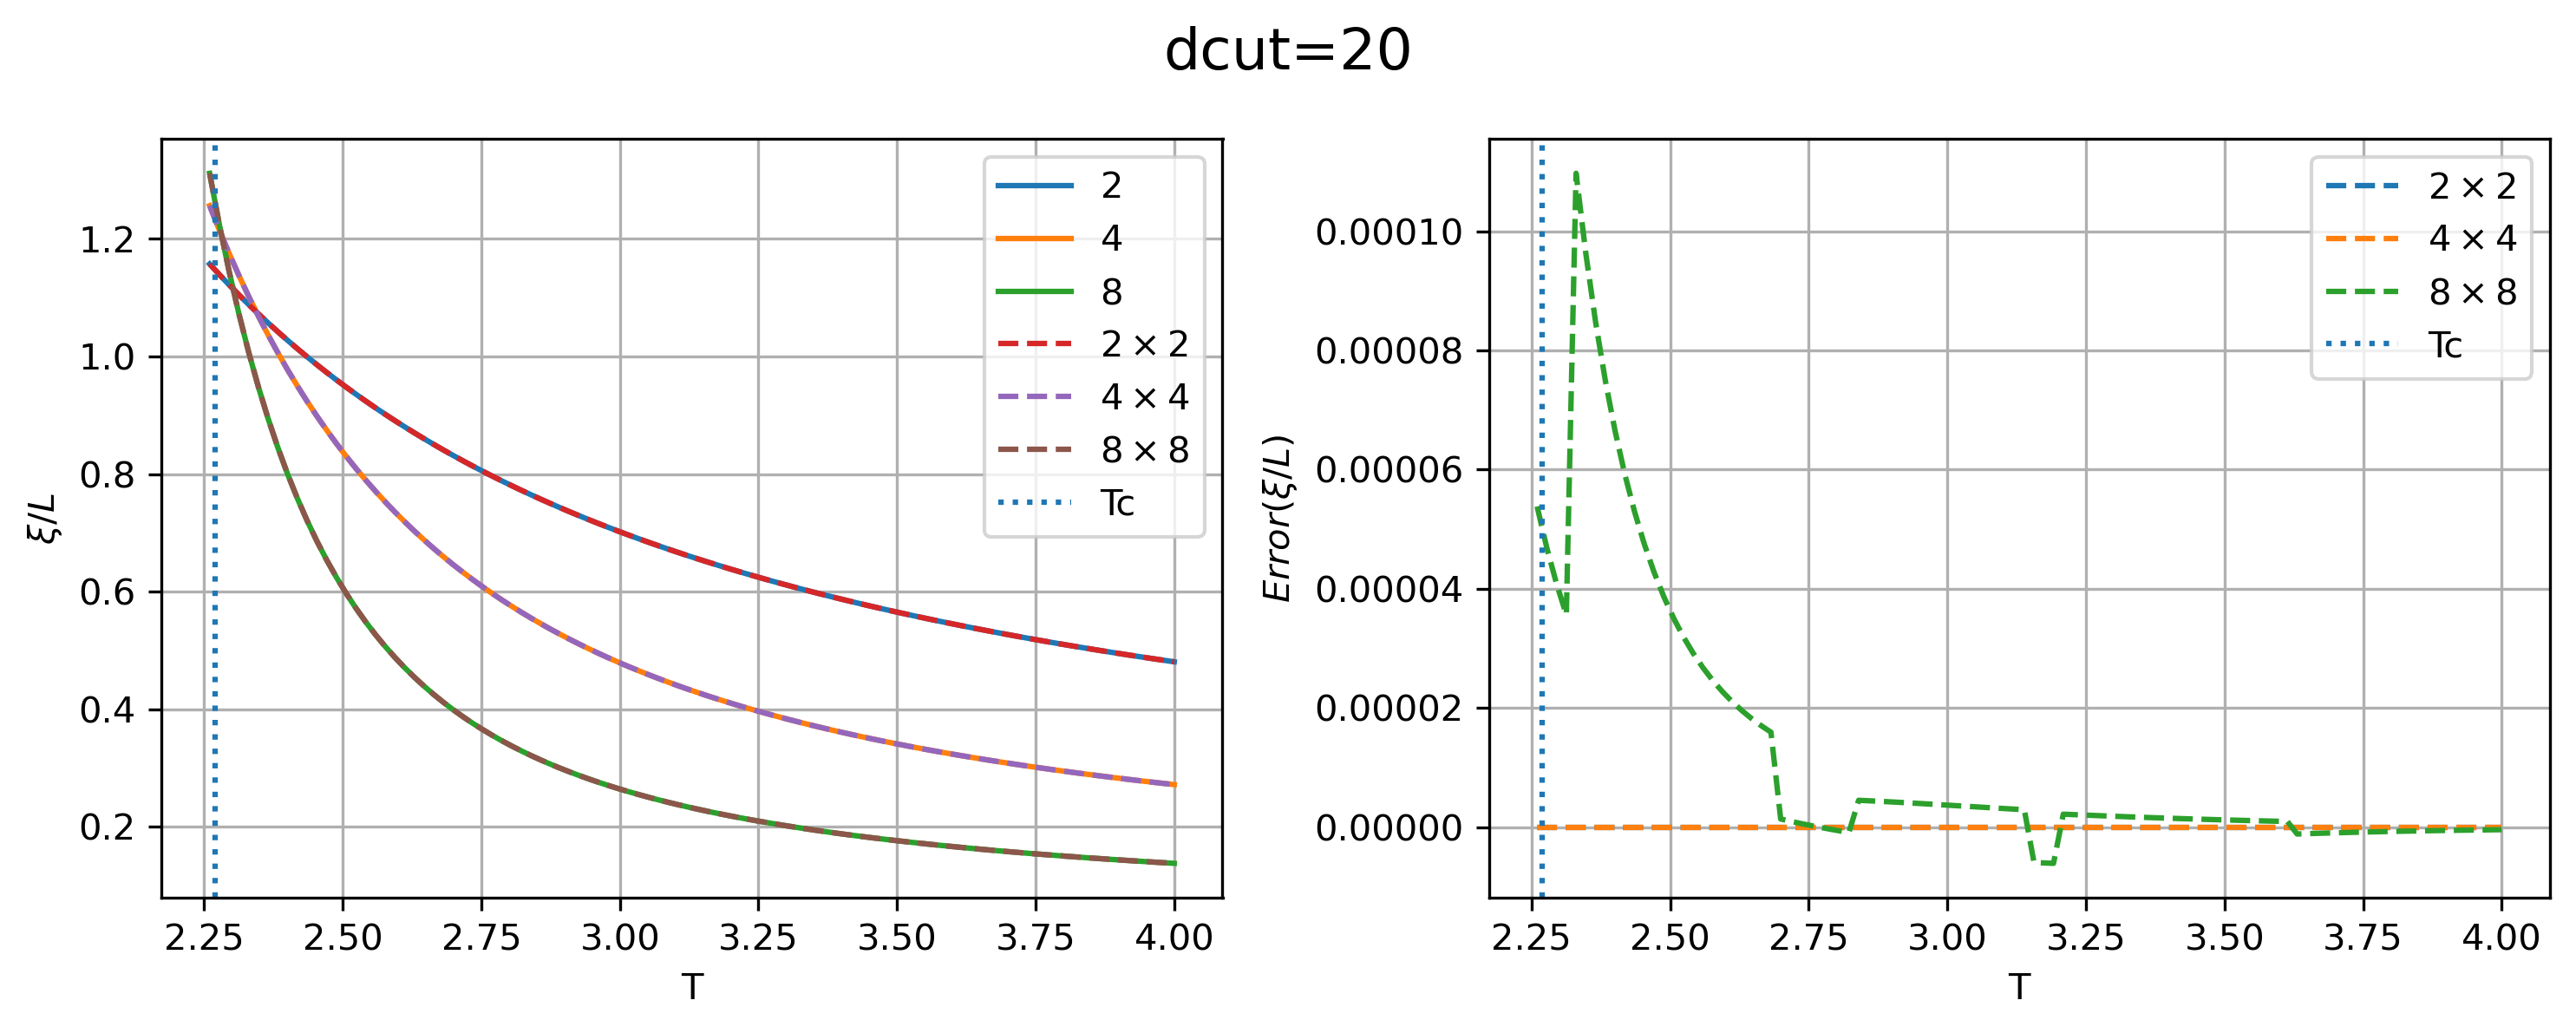

In [20]:
plt.figure(figsize = (10,4),dpi = 300)
plt.suptitle(f'dcut={dcut}',fontsize = 16)
plt.subplot(1,2,1)
for i in range(2,MaxL+1):
    plt.plot(Temp1,Corr_len1[i]/2**(i-1),'-',label = f'${2**(i-1)}$')
for i in range(2,MaxL+1):
    plt.plot(Temp,Corr_len[i],'--',label = f'${2**(i-1)}\\times{2**(i-1)}$')
plt.axvline(x=Tc,ls=':',label = 'Tc')
plt.xlabel('T')
plt.ylabel(r'$\xi/L$')
plt.grid()
plt.legend()
plt.subplot(1,2,2)
for i in range(2,MaxL+1):
    plt.plot(Temp,Corr_len[i] - (Corr_len1[i]/2**(i-1)),'--',label = f'${2**(i-1)}\\times{2**(i-1)}$')
plt.axvline(x=Tc,ls=':',label = 'Tc')
plt.xlabel('T')
plt.ylabel(r'$Error(\xi/L)$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# N*N truncate

## $Max = 128\times 128$

In [21]:
MaxL = 8
dcut = 20
Temp = np.linspace(2.26,2.36,100)
W = np.ones((MaxL+1,len(Temp),2))
E = np.ones((MaxL+1,len(Temp),2))
Tc = 2/np.log(1+np.sqrt(2))

In [22]:
%%time
for i,temp in enumerate(Temp):
    T_bare = get_T_baret(temp) 
    TL = T_bare
    for j in range(2,MaxL+1):
        TLx = merge_x_truncate(TL,TL,dcut)
        TL_Trace = merge_y(TLx,TLx,True,True)
        w,v = cytnx.linalg.Eigh(TL_Trace.get_block())
        W[j,i,:] = w[-2:].numpy()
        TL = merge_y_truncate(TLx,TLx,dcut)
        TL = TL/np.mean(np.abs(TL.get_block().numpy()))
E = -np.log(W)
Corr_len = 1/(E[:,:,-2]-E[:,:,-1])

CPU times: user 1h 39min 39s, sys: 7min 40s, total: 1h 47min 19s
Wall time: 2min 49s


/home/TCC0731/anaconda3/envs/cytnx/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


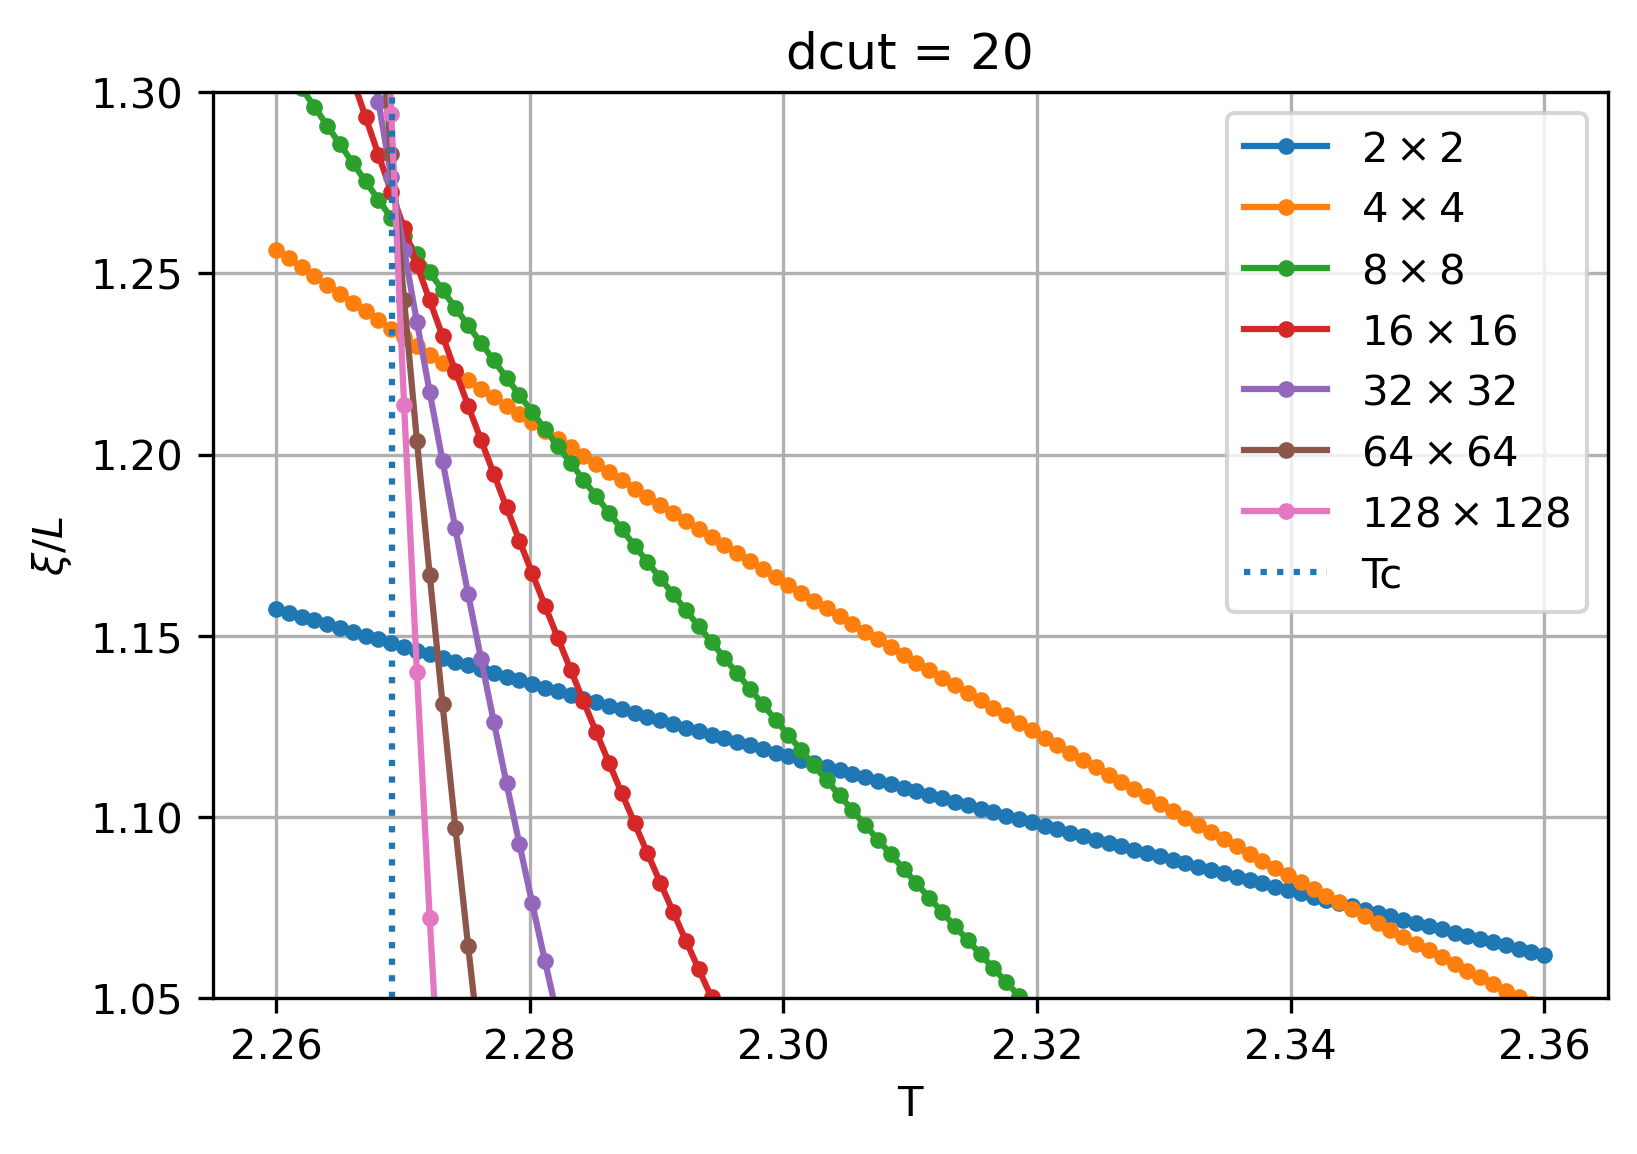

In [23]:
plt.figure(dpi = 300)
plt.title(f'dcut = {dcut}')
for i in range(2,MaxL+1):
    plt.plot(Temp,Corr_len[i],'.-',label = f'${2**(i-1)}\\times{2**(i-1)}$')
plt.axvline(x=Tc,ls=':',label = 'Tc')
plt.xlabel('T')
plt.ylabel(r'$\xi/L$')
plt.ylim((1.05,1.3))
plt.grid()
plt.legend()
plt.show()

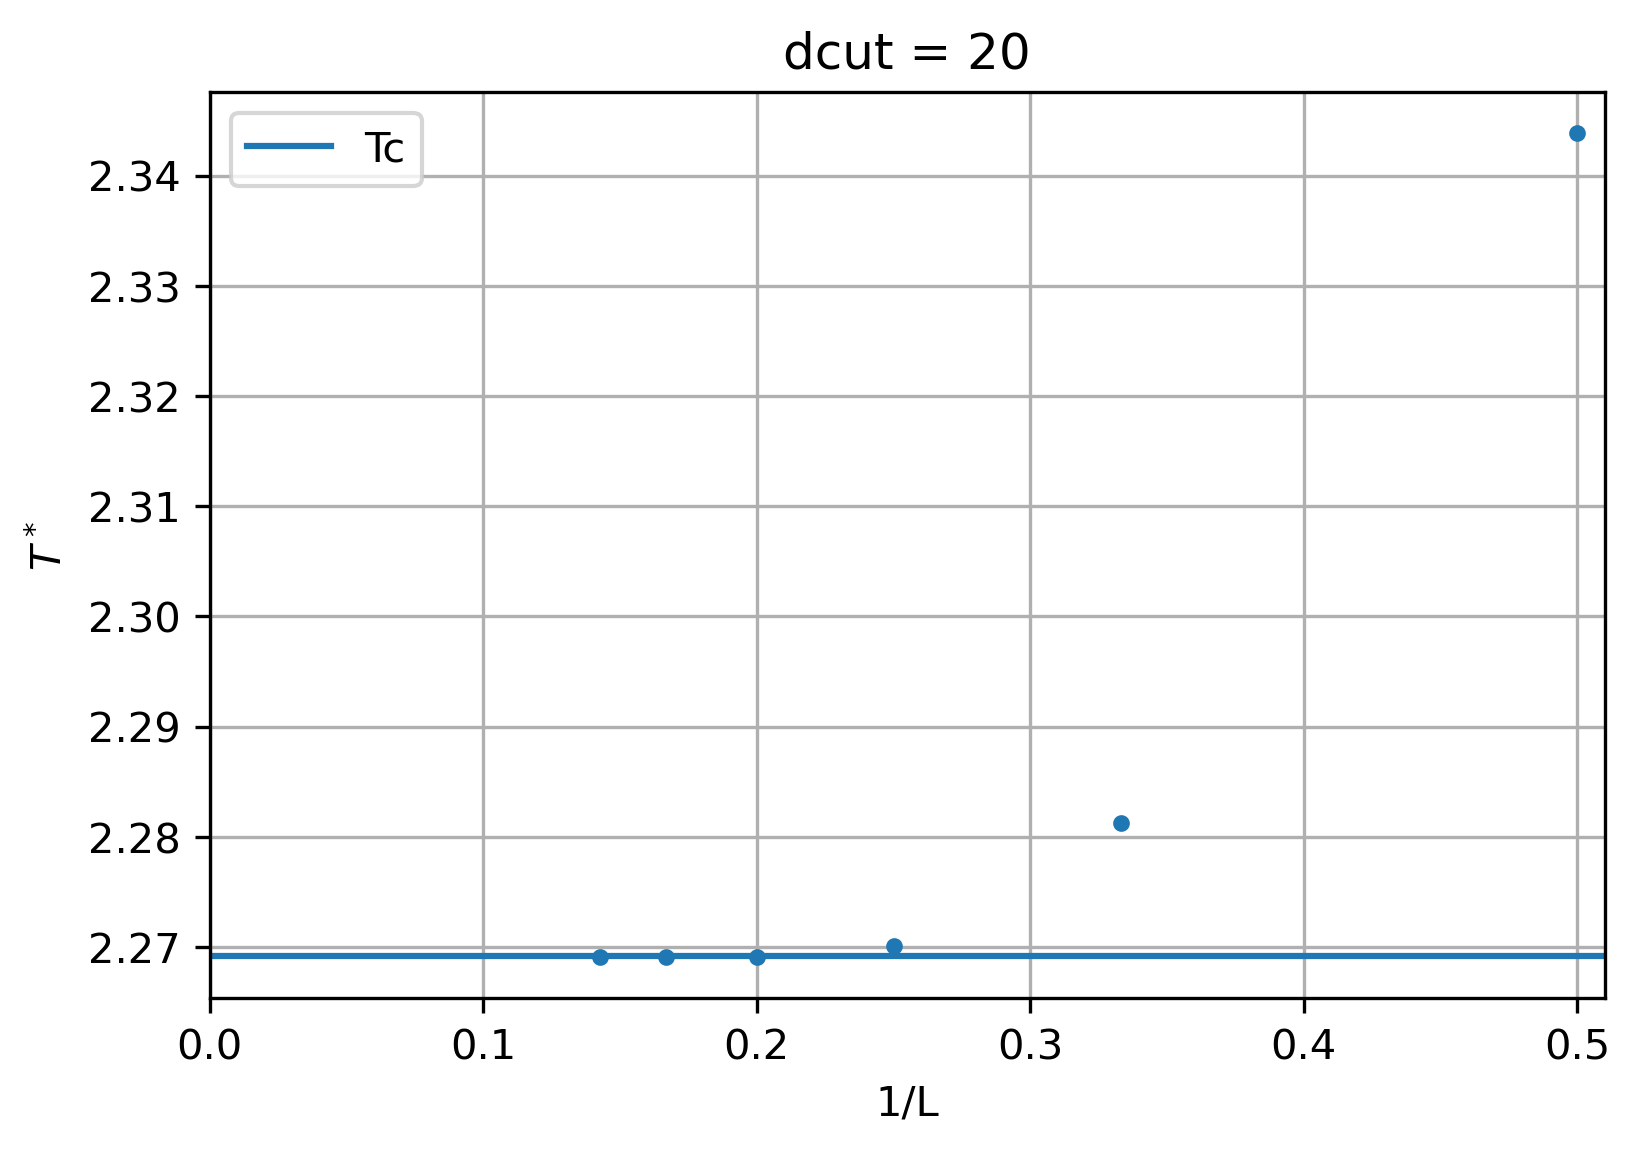

In [24]:
T_star = []
plt.figure(dpi = 300)
plt.title(f'dcut = {dcut}')
for i in range(2,MaxL):
    T_star.append(Temp[np.argmin(np.abs(Corr_len[i]-Corr_len[i+1]))])
    #print(T_star[-1])
plt.axhline(Tc,label = 'Tc')
plt.plot(1/np.arange(2,MaxL),T_star,'.')
#plt.axvline(x=T_star,label = '$T^*_{1,3}$')
plt.xlabel('1/L')
plt.ylabel(r'$T^*$')
plt.xlim(0,0.51)
plt.grid()
plt.legend()
plt.show()

# Secant_Method

In [25]:
def f(temp, MaxL, dcut = 20):
    T_bare = get_T_baret(temp) 
    TL = T_bare
    for j in range(2,MaxL+1):
        TLx = merge_x_truncate(TL,TL,dcut)
        TL = merge_y_truncate(TLx,TLx,dcut)
        TL = TL/np.mean(np.abs(TL.get_block().numpy()))
    TL_Trace = merge_y(TLx,TLx,True,True)
    w1,_ = cytnx.linalg.Eigh(TL_Trace.get_block())
    E1 = -np.log(w1[-2:].numpy())
    Corr_len1 = 1/(E1[-2]-E1[-1])
    TLx = merge_x_truncate(TL,TL,dcut)
    TL = merge_y_truncate(TLx,TLx,dcut)
    TL = TL/np.mean(np.abs(TL.get_block().numpy()))
    TL_Trace = merge_y(TLx,TLx,True,True)
    w2,_ = cytnx.linalg.Eigh(TL_Trace.get_block())
    E2 = -np.log(w2[-2:].numpy())
    Corr_len2 = 1/(E2[-2]-E2[-1])
    return Corr_len1-Corr_len2

def Secant_Method(func,x0,x1,Maxiter,MaxL,dcut):
    x = [x0,x1]
    func_out = [func(x0,MaxL,dcut)]
    for i in range(Maxiter):
        if (x[-1] - x[-2]) == 0:
            break
        func_out.append(func(x[-1],MaxL,dcut))
        if (func_out[-1] - func_out[-2]) == 0:
            break
        if np.abs(func_out[-1]) <= 1e-13:
            break
        new_x = x[-1] - func_out[-1] * (x[-1] - x[-2]) / (func_out[-1] - func_out[-2])
        x.append(new_x)
        #print(i,x[-1],func_out[-1])
    return x[-1]

## $Max = 128\times 128$

In [26]:
MaxL = 10
dcuts = [4,6,8,12,16,24,32]
Temp = np.linspace(2.26,2.36,50)
Tc = 2/np.log(1+np.sqrt(2))
T_stars = []

In [27]:
%%time
for dcut in dcuts:
    T_star = [2.36]
    print("dcut =",dcut)
    for i in range(2,MaxL):
        #print(i , 2**(i-1))
        T_star.append(Secant_Method(f,2.26,T_star[-1],10,i,dcut))
        print(i , 2**(i-1),T_star[-1])
    T_stars.append(T_star)
T_stars = np.array(T_stars)

dcut = 4
2 2 2.385085894698106
3 4 2.28688211237542
4 8 2.261419771082603
5 16 2.250799901894488
6 32 2.2458448192152596
7 64 2.2436082949919824
8 128 2.2426586516563605
9 256 2.3925427616909816
dcut = 6
2 2 2.347152961579803
3 4 2.2859185962603688
4 8 2.2769242297418972
5 16 2.2749270386678737
6 32 2.273458581048247
7 64 2.272410544612898
8 128 2.27179077912138
9 256 2.2714758877429375
dcut = 8
2 2 2.346242839684042
3 4 2.2835677421588665
4 8 2.2735840725983207
5 16 2.2719864402533867
6 32 2.270926944099856
7 64 2.2700962621333907
8 128 2.269535093089755
9 256 2.2692066330623355
dcut = 12
2 2 2.344015591860287
3 4 2.281971379981294
4 8 2.271305444170546
5 16 2.2702868120954642
6 32 2.2699503744696656
7 64 2.2697072011056294
8 128 2.2695332859462303
9 256 2.2694157012666443
dcut = 16
2 2 2.344018282935605
3 4 2.2814852330912214
4 8 2.2707786170741087
5 16 2.26980700490905
6 32 2.269674349309153
7 64 2.269583970804568
8 128 2.2695020401600265
9 256 2.269438487970879
dcut = 24
2 2 2.3440

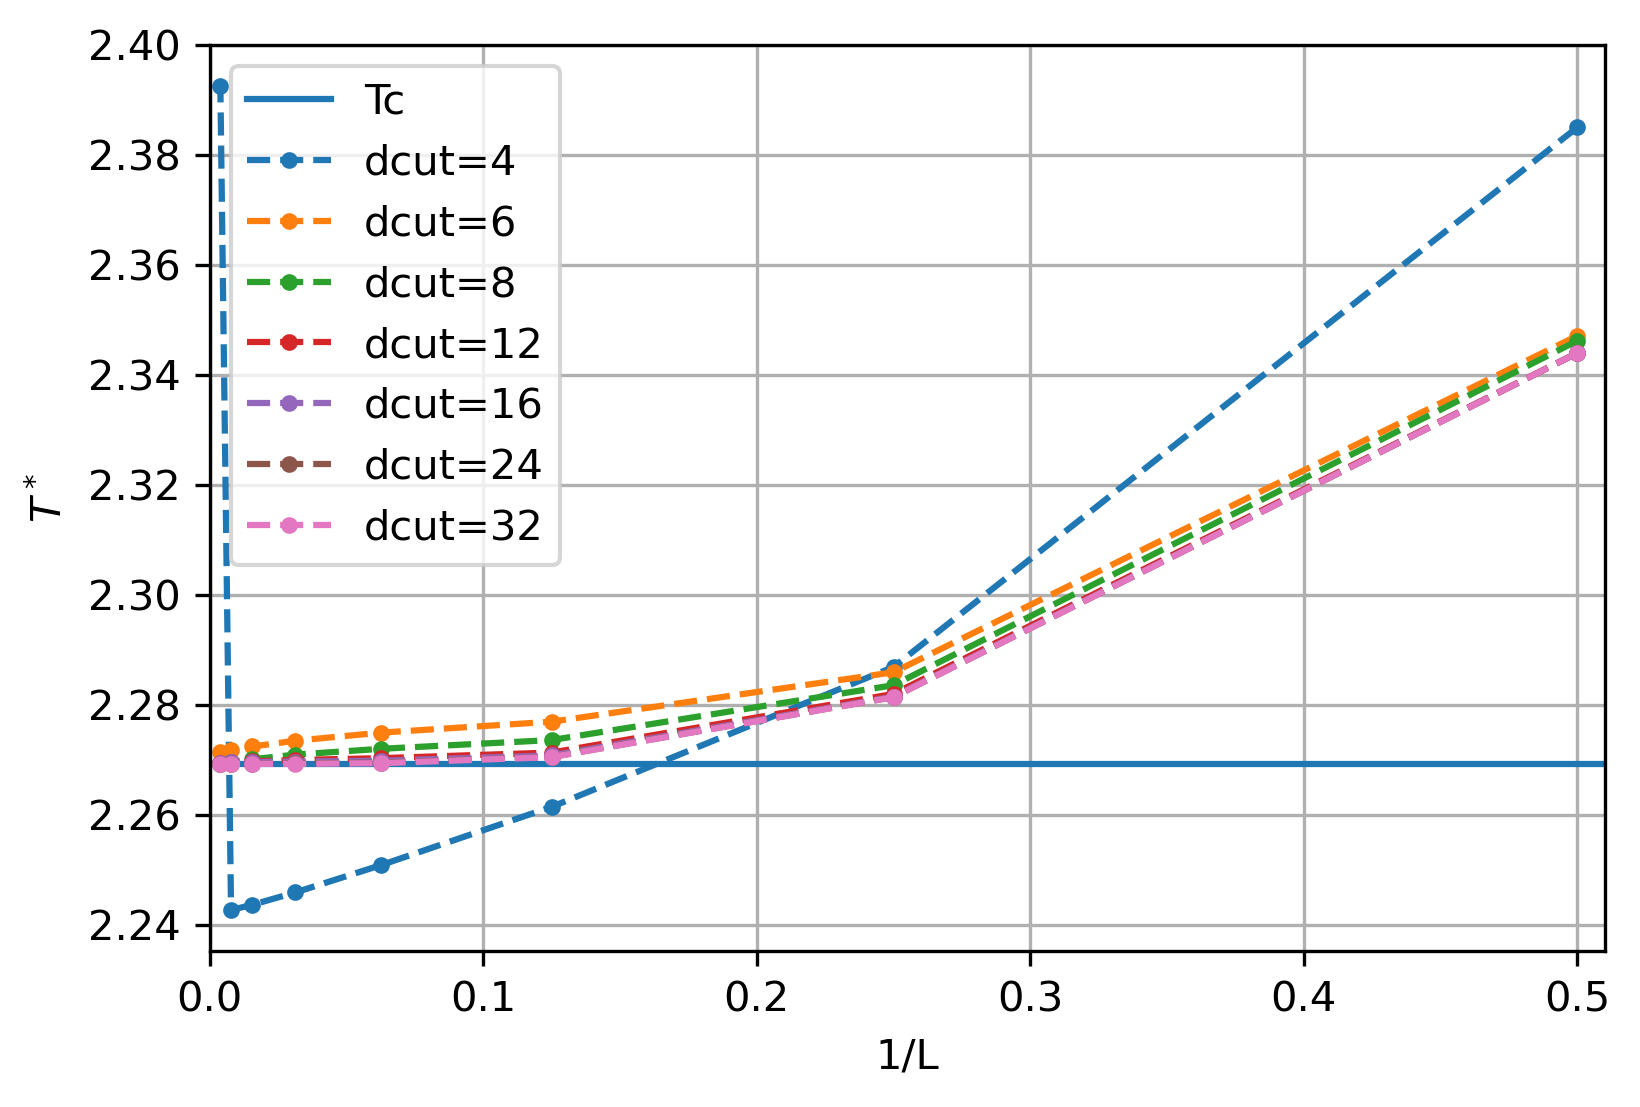

In [28]:
plt.figure(dpi = 300)
plt.axhline(Tc,label = 'Tc')
for i,dcut in enumerate(dcuts):
    plt.plot(1/2**(np.arange(2,MaxL)-1),T_stars[i,1:],'--.', label = f'dcut={dcut}')
#plt.axvline(x=T_star,label = '$T^*_{1,3}$')
plt.xlabel('1/L')
plt.ylabel(r'$T^*$')
plt.xlim(0,0.51)
plt.grid()
plt.legend(loc = 2)
plt.show()

/home/TCC0731/anaconda3/envs/cytnx/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


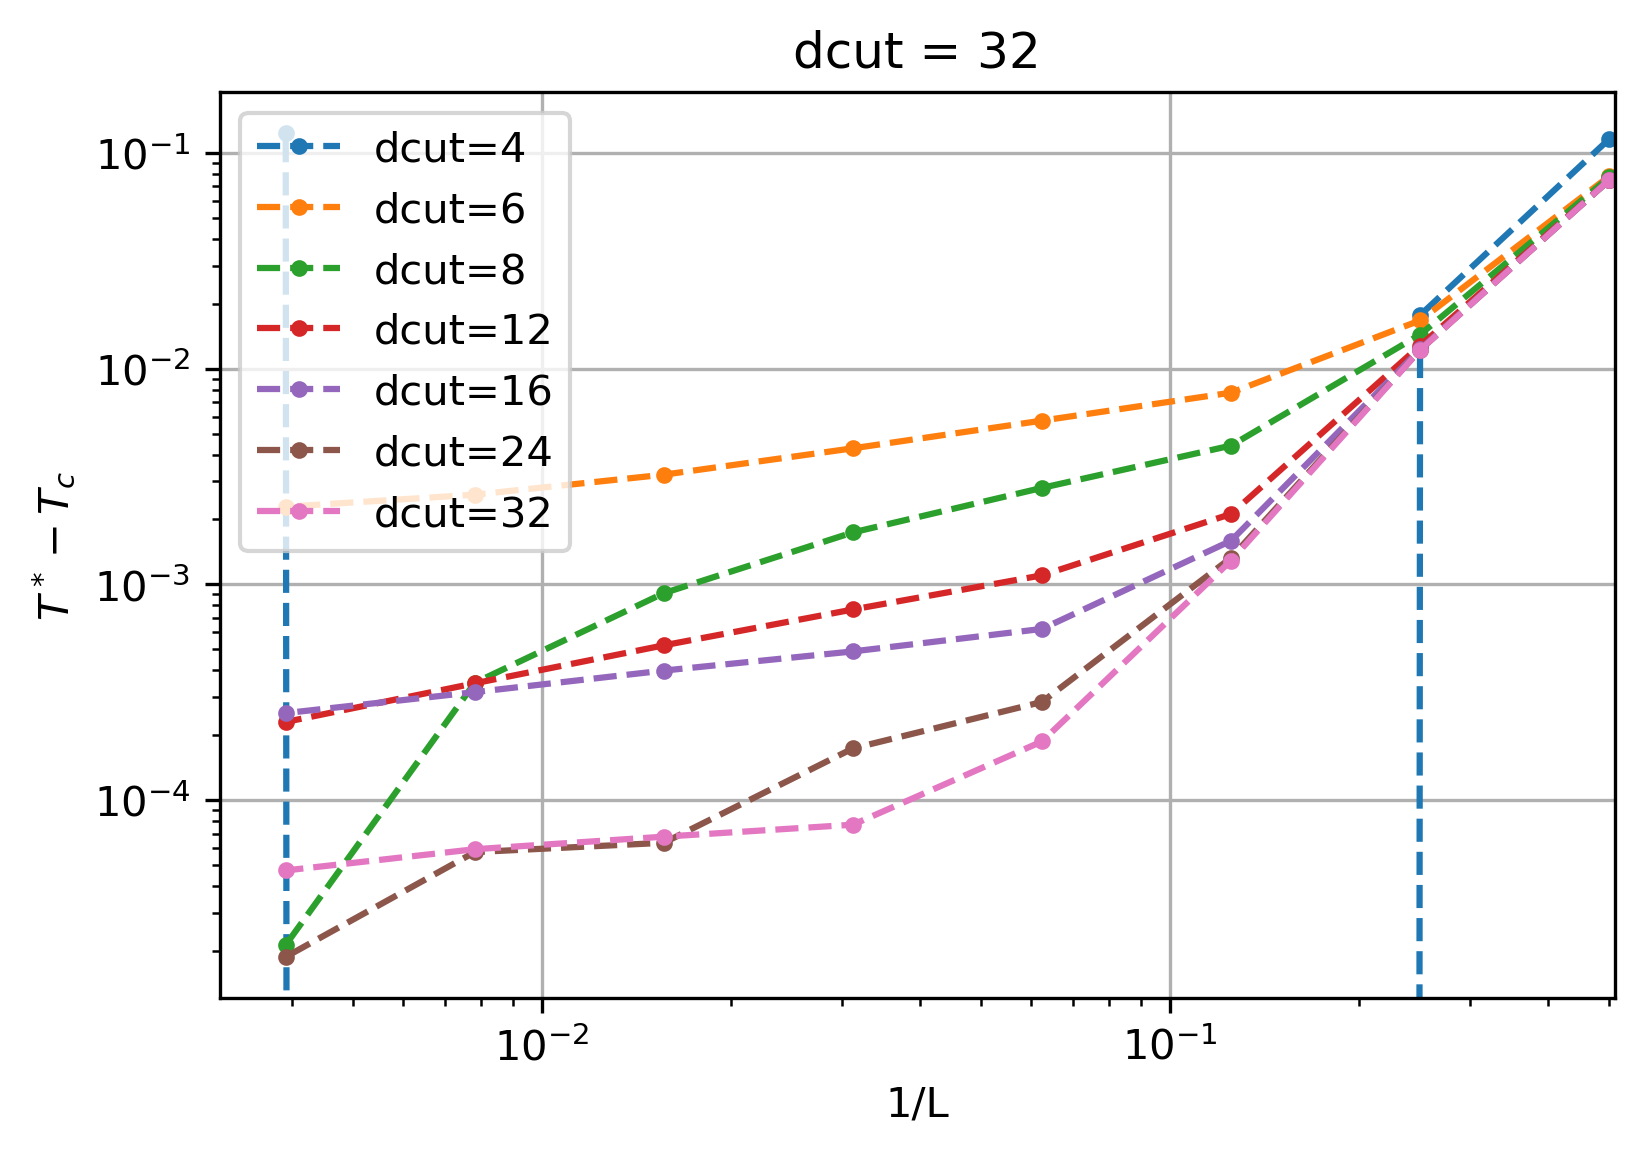

In [29]:
plt.figure(dpi = 300)
for i,dcut in enumerate(dcuts):
    plt.plot(1/2**(np.arange(2,MaxL)-1),T_stars[i,1:]-Tc,'--.', label = f'dcut={dcut}')
plt.xlabel('1/L')
plt.ylabel(r'$T^*-T_c$')
plt.yscale('log')
plt.xscale('log')
plt.xlim(0,0.51)
plt.grid()
plt.legend(loc = 2)
plt.show()

### Fit curve

/home/TCC0731/anaconda3/envs/cytnx/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


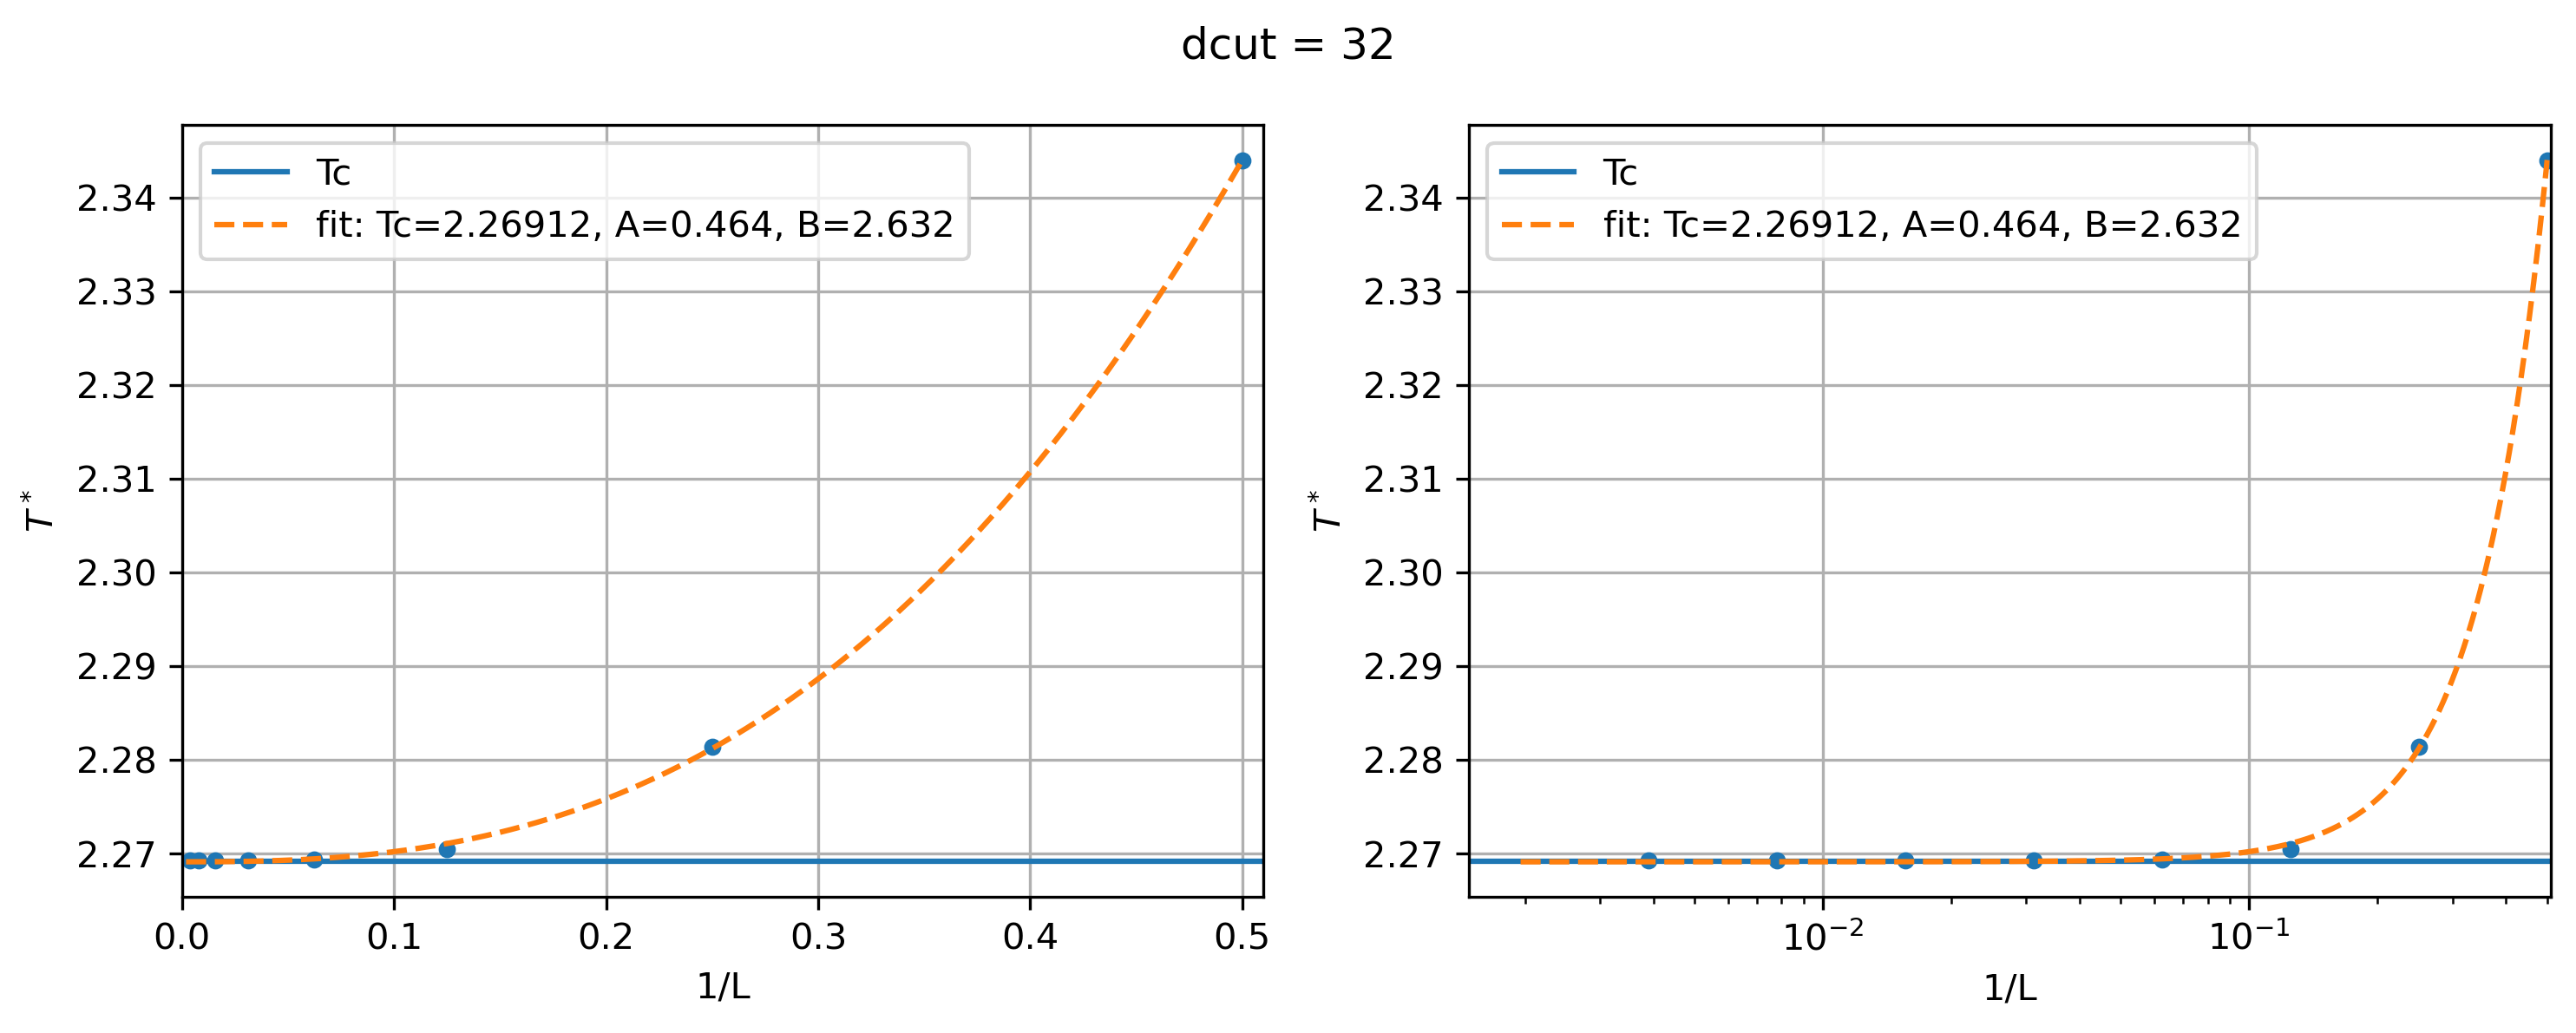

In [30]:
def func(x, tc, A, B):
    return tc + A * (x**B)
popt, pcov = curve_fit(func, 1/2**(np.arange(2,MaxL)-1),T_stars[-1][1:])
plt.figure(figsize = (10,4),dpi = 300)
plt.suptitle(f'dcut = {dcuts[-1]}')
plt.subplot(1,2,1)
plt.axhline(Tc,label = 'Tc')
plt.plot(1/2**(np.arange(2,MaxL)-1),T_stars[-1][1:],'.',ms = 7.5)
plt.plot(np.linspace(1/2**(MaxL-1),0.5,1000), func(np.linspace(1/2**(MaxL-1),0.5,1000), *popt), '--',
         label='fit: Tc=%.5f, A=%.3f, B=%.3f' % tuple(popt))
plt.xlabel('1/L')
plt.ylabel(r'$T^*$')
plt.xlim(0,0.51)
plt.grid()
plt.legend(loc = 2)
plt.subplot(1,2,2)
plt.axhline(Tc,label = 'Tc')
plt.plot(1/2**(np.arange(2,MaxL)-1),T_stars[-1][1:],'.',ms = 7.5)
plt.plot(np.geomspace(1/2**(MaxL-1),0.5,1000), func(np.geomspace(1/2**(MaxL-1),0.5,1000), *popt), '--',
         label='fit: Tc=%.5f, A=%.3f, B=%.3f' % tuple(popt))
plt.xlabel('1/L')
plt.ylabel(r'$T^*$')
plt.xscale('log')
plt.xlim(0,0.51)
plt.grid()
plt.legend(loc = 2)
plt.tight_layout()
plt.show()

## $Max = 1048576 \times 1048576$

In [31]:
MaxL = 22
dcuts = [4,6,8,12,16]
Temp = np.linspace(2.26,2.36,50)
Tc = 2/np.log(1+np.sqrt(2))
T_stars = []

In [32]:
%%time
for dcut in dcuts:
    T_star = [2.36]
    print("dcut =",dcut)
    for i in range(2,MaxL):
        #print(i , 2**(i-1))
        T_star.append(Secant_Method(f,2.265,T_star[-1],10,i,dcut))
        print(i , 2**(i-1),T_star[-1])
    T_stars.append(T_star)
T_stars = np.array(T_stars)

dcut = 4
2 2 2.385085894698109
3 4 2.2868821123754226
4 8 2.2614197710826027
5 16 2.2507999018944886
6 32 2.2458448192152587
7 64 2.2436082949919833
8 128 2.2426586516563582
9 256 2.40101592619384
10 512 2.4031593930890898
11 1024 2.3990381798016744
12 2048 2.303953059569899
13 4096 2.3074692984959815
14 8192 2.2726539640507313
15 16384 2.272160791380777
16 32768 2.266344436278943
17 65536 2.266307612968497
18 131072 2.2657481660855665
19 262144 2.2653368445959794
20 524288 2.2649726744638934
21 1048576 2.2649794560661736
dcut = 8
2 2 2.3462428396840402
3 4 2.283567742158867
4 8 2.2735840725983283
5 16 2.2719864402533863
6 32 2.2709269440998567
7 64 2.2700962621333907
8 128 2.269535093089755
9 256 2.269206633062336
10 512 2.26903596886478
11 1024 2.2689555640029093
12 2048 2.268920575384742
13 4096 2.2689062766995085
14 8192 2.268900707401946
15 16384 2.2688986137719565
16 32768 2.2688978463776897
17 65536 2.2688975699600777
18 131072 2.2688974715488555
19 262144 2.268897436779028
20 5

/home/TCC0731/anaconda3/envs/cytnx/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


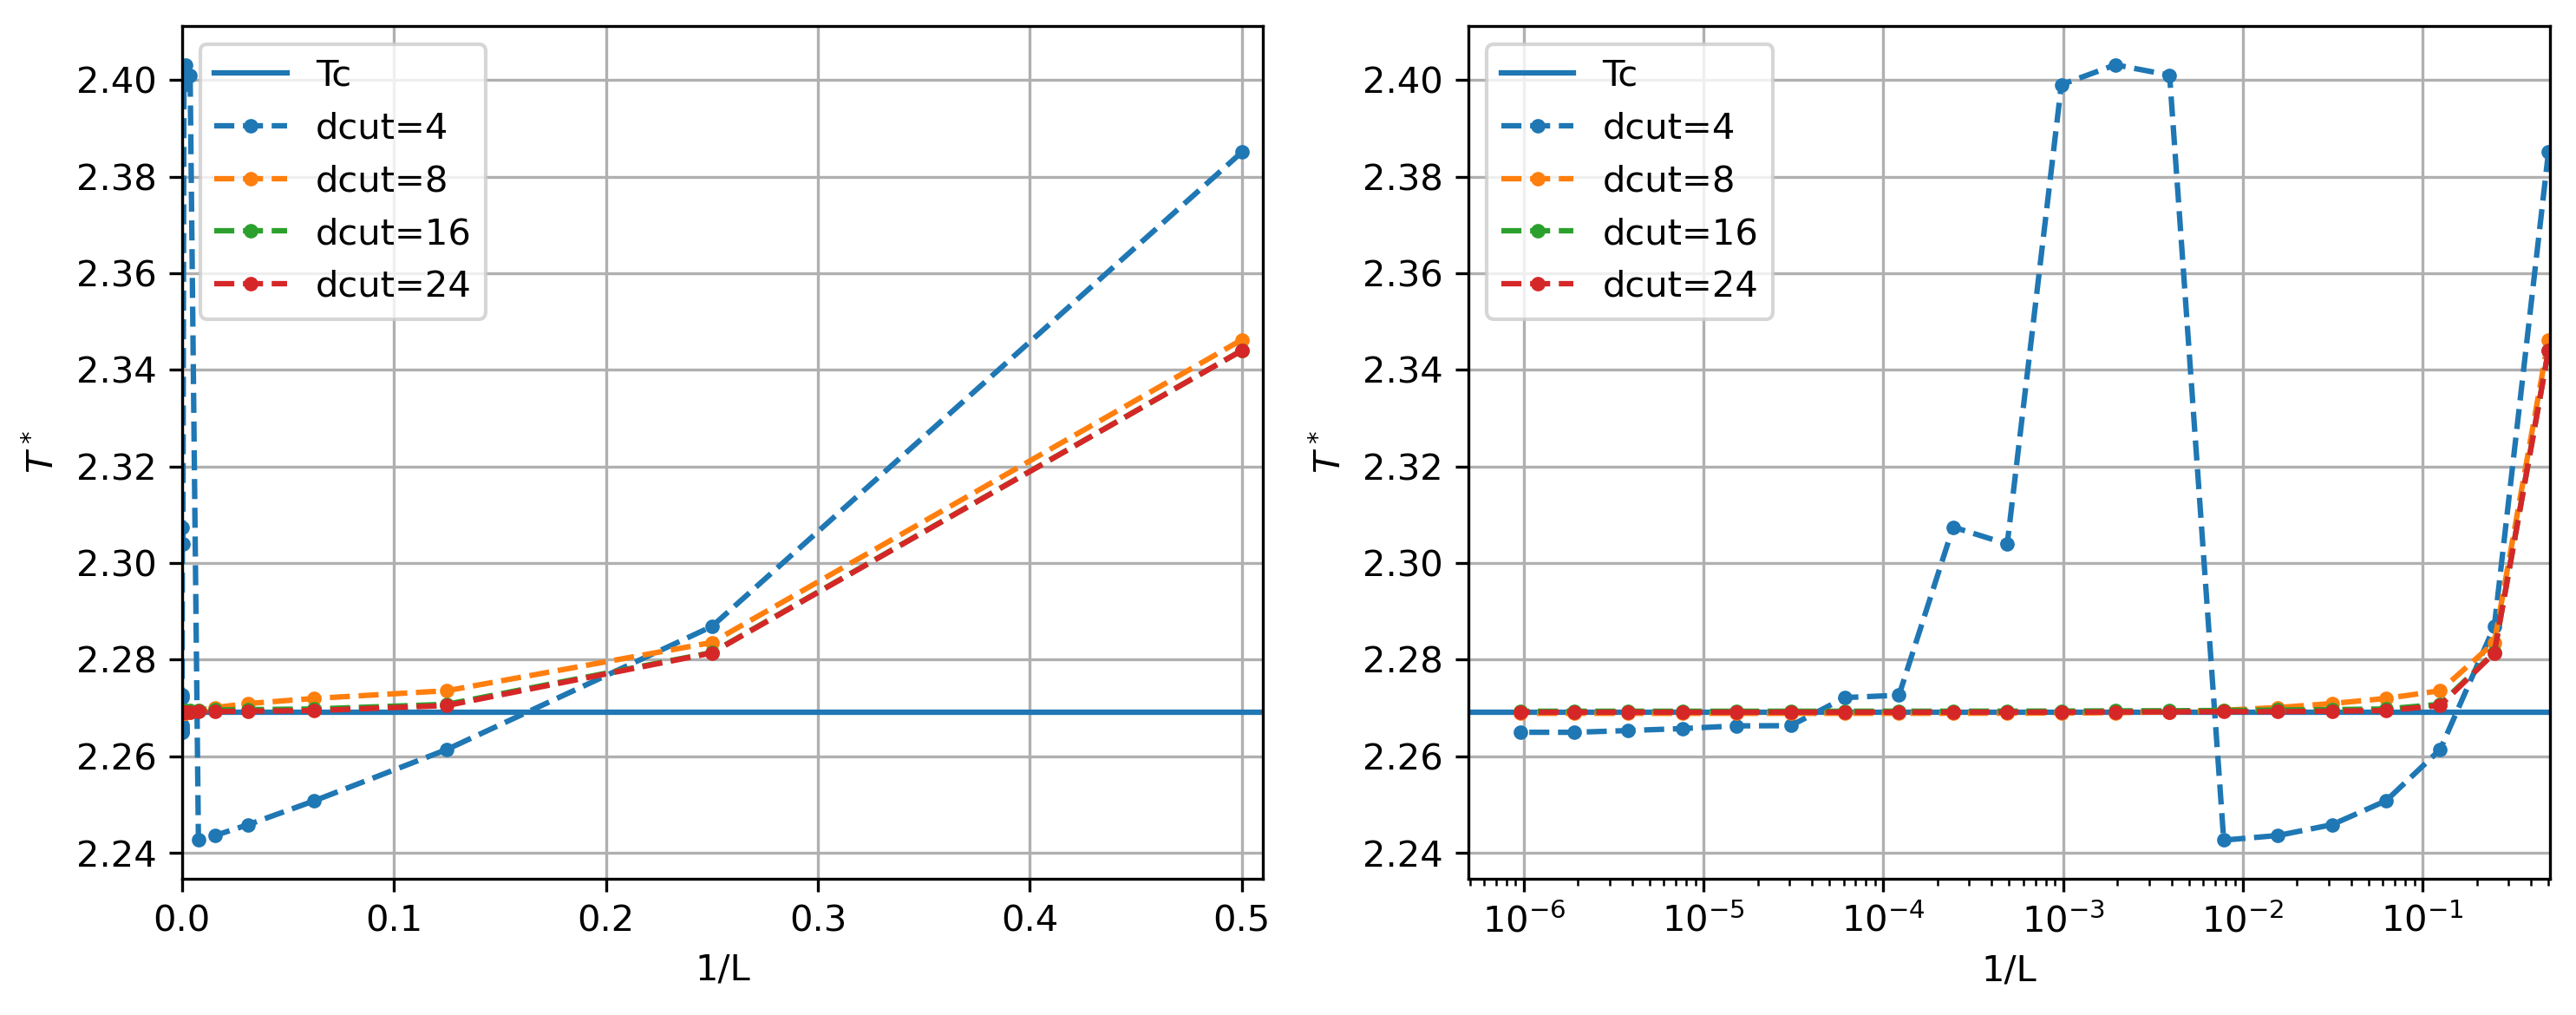

In [33]:
plt.figure(figsize = (10,4),dpi = 300)
plt.subplot(1,2,1)
plt.axhline(Tc,label = 'Tc')
for i,dcut in enumerate(dcuts):
    plt.plot(1/2**(np.arange(2,MaxL)-1),T_stars[i,1:],'--.', label = f'dcut={dcut}')
#plt.axvline(x=T_star,label = '$T^*_{1,3}$')
plt.xlabel('1/L')
plt.ylabel(r'$T^*$')
plt.xlim(0,0.51)
plt.grid()
plt.legend(loc = 2)
plt.subplot(1,2,2)
plt.axhline(Tc,label = 'Tc')
for i,dcut in enumerate(dcuts):
    plt.plot(1/2**(np.arange(2,MaxL)-1),T_stars[i,1:],'--.', label = f'dcut={dcut}')
#plt.axvline(x=T_star,label = '$T^*_{1,3}$')
plt.xlabel('1/L')
plt.ylabel(r'$T^*$')
plt.xscale('log')
plt.xlim(0,0.51)
plt.grid()
plt.legend(loc = 2)
plt.tight_layout()
plt.show()

/home/TCC0731/anaconda3/envs/cytnx/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


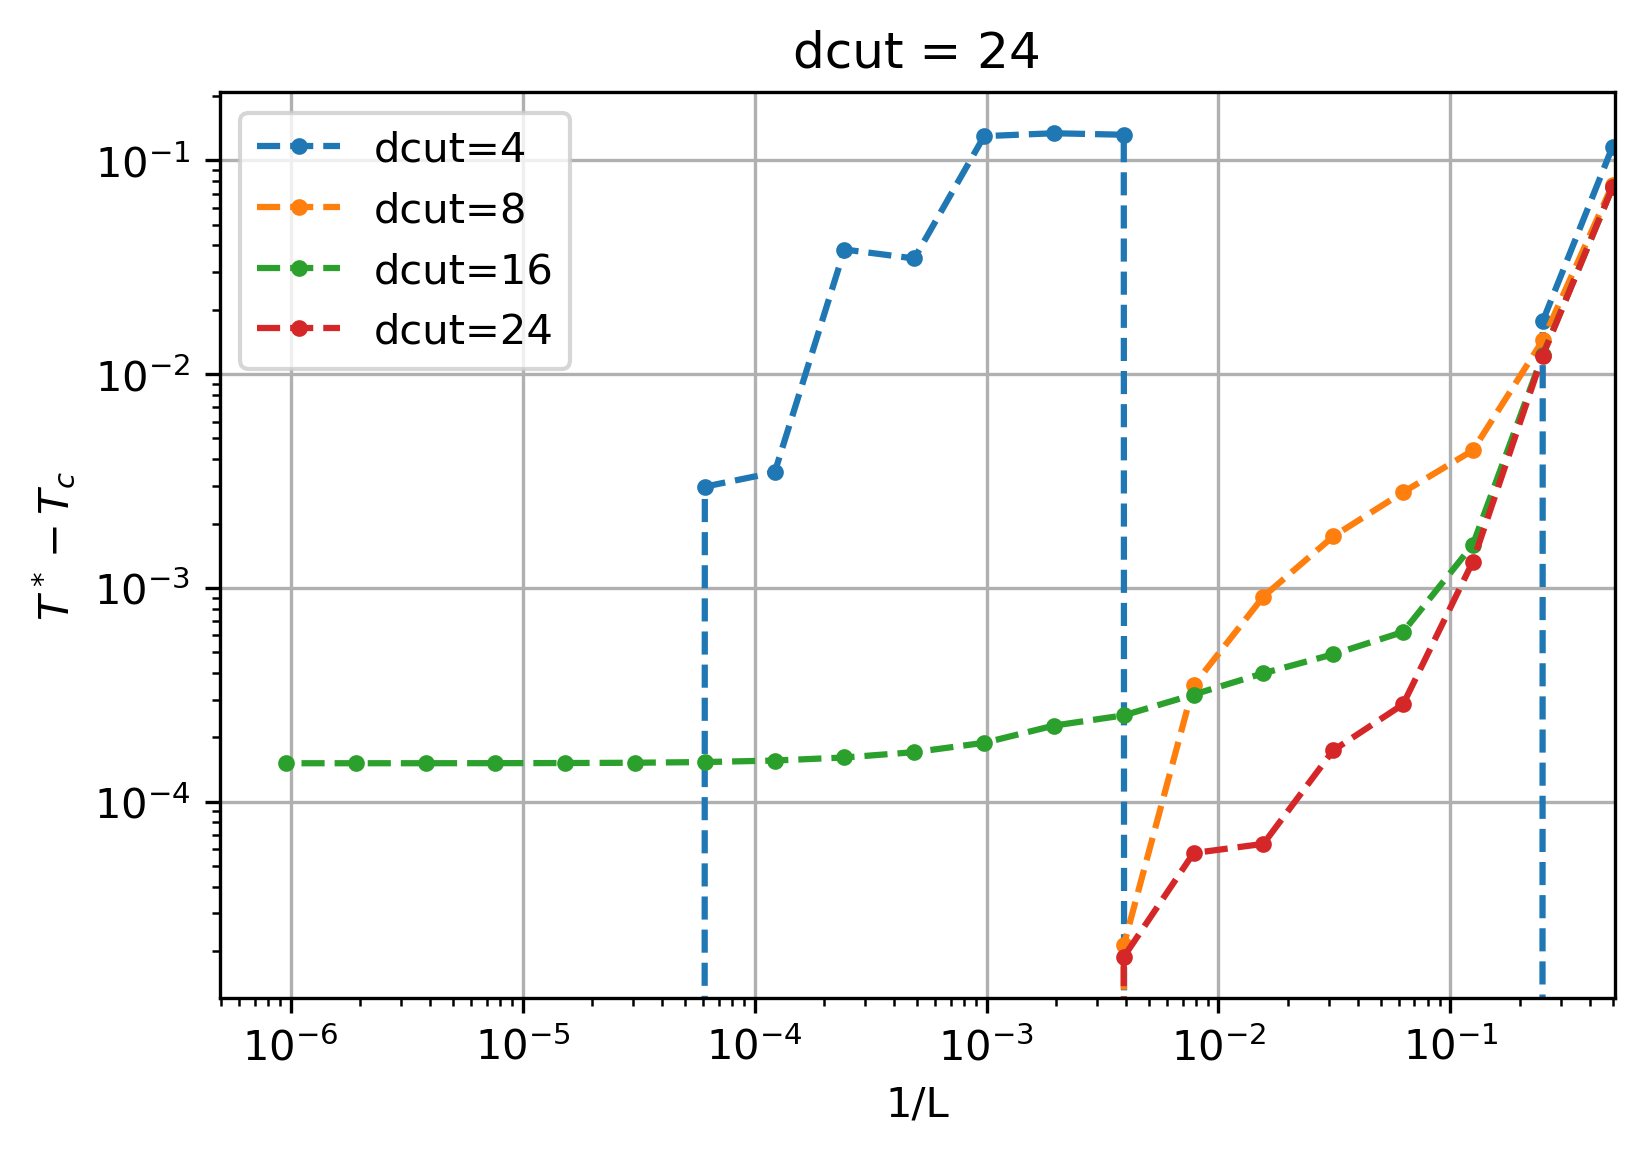

In [34]:
plt.figure(dpi = 300)
for i,dcut in enumerate(dcuts):
    plt.plot(1/2**(np.arange(2,MaxL)-1),T_stars[i,1:]-Tc,'--.', label = f'dcut={dcut}')
plt.xlabel('1/L')
plt.ylabel(r'$T^*-T_c$')
plt.yscale('log')
plt.xscale('log')
plt.xlim(0,0.51)
plt.grid()
plt.legend(loc = 2)
plt.show()

### Fit curve

/home/TCC0731/anaconda3/envs/cytnx/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


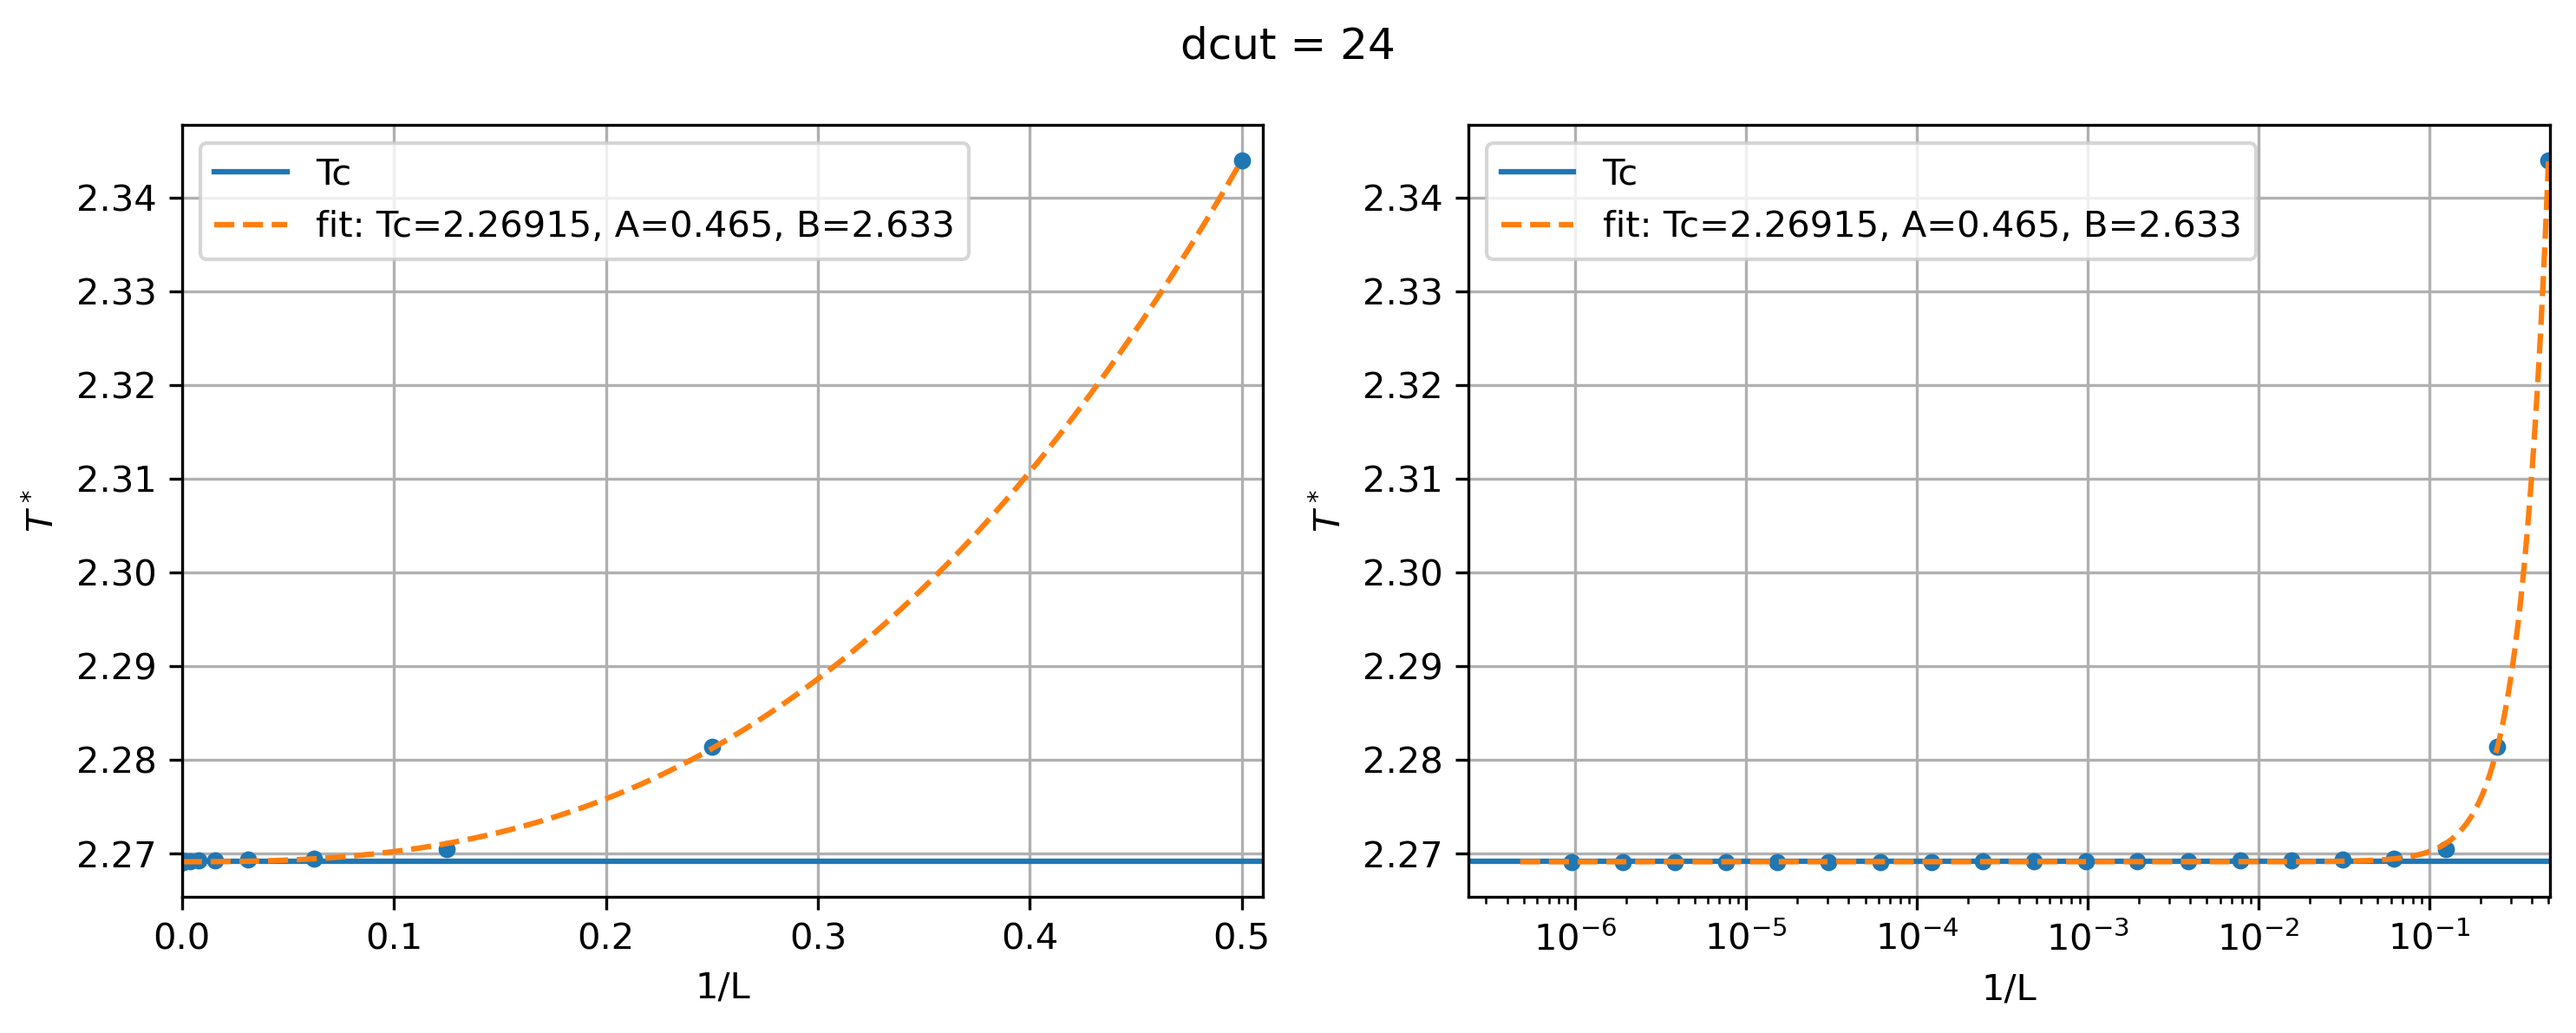

In [35]:
def func(x, tc, A, B):
    return tc + A * (x**B)
popt, pcov = curve_fit(func, 1/2**(np.arange(2,MaxL)-1),T_stars[-1][1:])
plt.figure(figsize = (10,4),dpi = 300)
plt.suptitle(f'dcut = {dcuts[-1]}')
plt.subplot(1,2,1)
plt.axhline(Tc,label = 'Tc')
plt.plot(1/2**(np.arange(2,MaxL)-1),T_stars[-1][1:],'.',ms = 7.5)
plt.plot(np.linspace(1/2**(MaxL-1),0.5,1000), func(np.linspace(1/2**(MaxL-1),0.5,1000), *popt), '--',
         label='fit: Tc=%.5f, A=%.3f, B=%.3f' % tuple(popt))
plt.xlabel('1/L')
plt.ylabel(r'$T^*$')
plt.xlim(0,0.51)
plt.grid()
plt.legend(loc = 2)
plt.subplot(1,2,2)
plt.axhline(Tc,label = 'Tc')
plt.plot(1/2**(np.arange(2,MaxL)-1),T_stars[-1][1:],'.',ms = 7.5)
plt.plot(np.geomspace(1/2**(MaxL-1),0.5,1000), func(np.geomspace(1/2**(MaxL-1),0.5,1000), *popt), '--',
         label='fit: Tc=%.5f, A=%.3f, B=%.3f' % tuple(popt))
plt.xlabel('1/L')
plt.ylabel(r'$T^*$')
plt.xscale('log')
plt.xlim(0,0.51)
plt.grid()
plt.legend(loc = 2)
plt.tight_layout()
plt.show()